In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from string import digits as d, punctuation as p
from nltk.tokenize import word_tokenize as wt
from nltk.stem import WordNetLemmatizer as wl, PorterStemmer as porter
from gensim import corpora

from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV as rsv, cross_val_score as cvs
from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,roc_auc_score,confusion_matrix,log_loss,\
precision_score,recall_score,mean_squared_error

from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from PIL import Image
import requests
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',message="numpy.dtype size changed")
warnings.filterwarnings('ignore',message="numpy.ufunc size changed")
import joblib

In [2]:
df=pd.read_csv(r"C:\Users\ABHISHEK\CSV\HATE\train.csv")

test=pd.read_csv(r"C:\Users\ABHISHEK\CSV\HATE\test.csv")

In [3]:
df.head(7)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [4]:
test.head(7)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...


In [5]:
print("In the training dataset\nNumber of columns=",df.shape[1],'\nNumber of Rows=',df.shape[0],\
      '\nName of columns=\n',df.columns.values)

In the training dataset
Number of columns= 8 
Number of Rows= 159571 
Name of columns=
 ['id' 'comment_text' 'malignant' 'highly_malignant' 'rude' 'threat'
 'abuse' 'loathe']


In [6]:
print("In the test dataset\nNumber of columns=",test.shape[1],'\nNumber of Rows=',test.shape[0],\
      '\nName of columns=\n',test.columns.values)

In the test dataset
Number of columns= 2 
Number of Rows= 153164 
Name of columns=
 ['id' 'comment_text']


In [7]:
#checking if there is any duplicated values in training dataset
print('Number of duplicated values:-',df.duplicated().sum())

Number of duplicated values:- 0


In [8]:
#checking if there is any duplicated values in test dataset
print('Number of duplicated values:-',test.duplicated().sum())

Number of duplicated values:- 0


In [9]:
#checking for null values in training dataset
for i in df.columns:
    null=df[i].isnull().sum()
    if null>0:
        print('Number of Null Values At  '+"'"+ i+"'" ,'==  ',null )
    else:
        print('There are no null values in  '+"'"+ i+"'")

There are no null values in  'id'
There are no null values in  'comment_text'
There are no null values in  'malignant'
There are no null values in  'highly_malignant'
There are no null values in  'rude'
There are no null values in  'threat'
There are no null values in  'abuse'
There are no null values in  'loathe'


In [10]:
#checking for null values in test dataset
for i in test.columns:
    null=test[i].isnull().sum()
    if null>0:
        print('Number of Null Values At  '+"'"+ i+"'" ,'==  ',null )
    else:
        print('There are no null values in  '+"'"+ i+"'")

There are no null values in  'id'
There are no null values in  'comment_text'


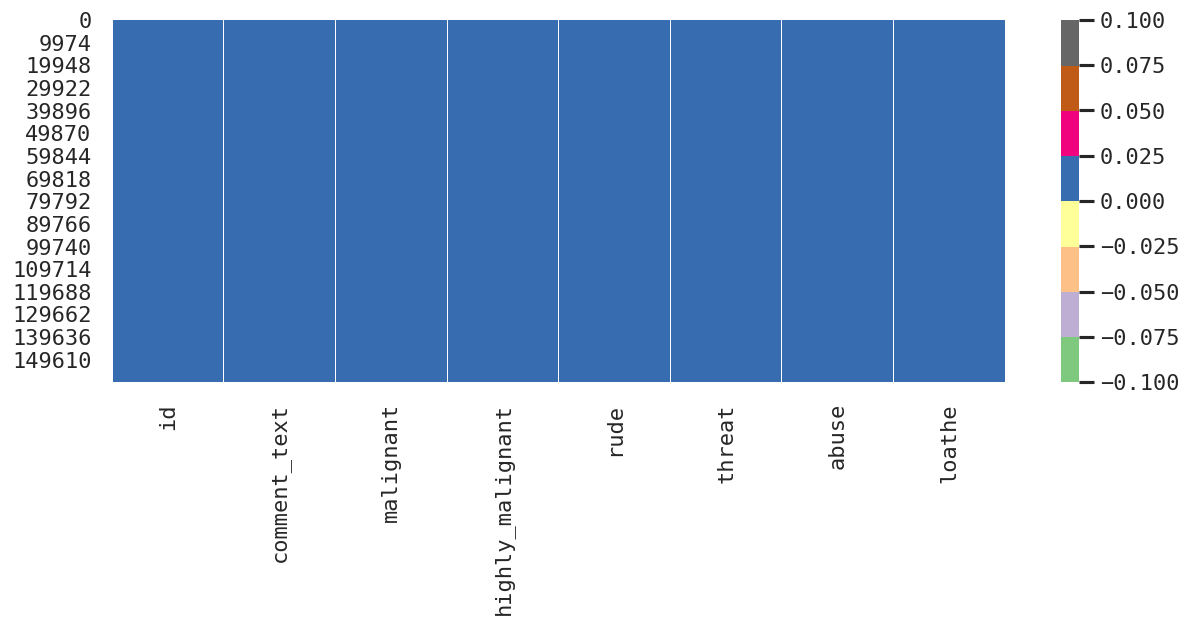

In [11]:
#heatmap of null values
sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.8)
plt.figure(figsize=(12,4),dpi=120)
sns.heatmap(df.isnull(),cmap='Accent')
plt.show()

In [12]:
#dropping unwanted columns as we'll be working on the comment_text and their categories_
cmt=df.copy()
cmt.drop(['id'],axis=1,inplace=True)

In [13]:
test.drop(['id'],axis=1,inplace=True)

In [14]:
#adding a new column which represent a normal statement

labels= ['malignant','highly_malignant','rude','threat','abuse','loathe']
cmt['normal']=1-cmt[labels].max(axis=1)

In [15]:
cmt.head(7)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0


```The column named 'normal' represents the columns which are not falling under 'malignant','highly_malignant','rude','threat','abuse','loathe' categories```

In [16]:
#adding a column 'raw length' to the dataset which will show the length of characters in column 'comment_text'
cmt['raw length']= cmt.comment_text.str.len().astype('int64')
cmt.head(7)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1,65
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,44


In [17]:
#value counts of  label columns
values=['malignant','highly_malignant','rude','threat','abuse','loathe']
for i in values:
    vc=cmt[i].value_counts()
    print('VALUE COUNT OF UNIQUE VALUES IN ' +"'"+ i+"' :\n ",vc,'\n')

VALUE COUNT OF UNIQUE VALUES IN 'malignant' :
  0    144277
1     15294
Name: malignant, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'highly_malignant' :
  0    157976
1      1595
Name: highly_malignant, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'rude' :
  0    151122
1      8449
Name: rude, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'threat' :
  0    159093
1       478
Name: threat, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'abuse' :
  0    151694
1      7877
Name: abuse, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'loathe' :
  0    158166
1      1405
Name: loathe, dtype: int64 



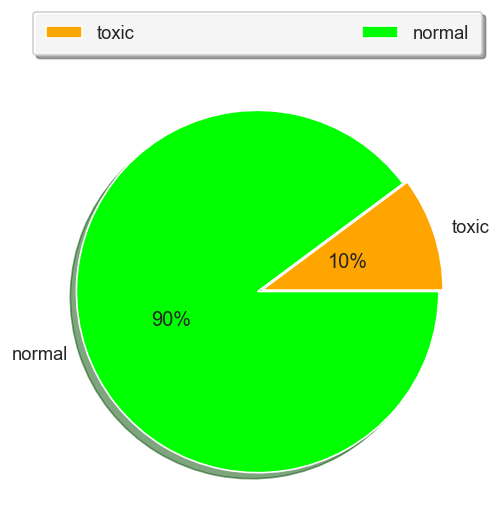

In [18]:
#Pie plot to show the percentage of toxic and normal comment
values=[cmt.shape[0]-cmt.normal.sum(),cmt.normal.sum()]
label=['toxic','normal']
exp=(0.025,0)
clr=('orange','lime')
plt.figure(figsize=(5,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
plt.pie(x=values,explode=exp,labels=label,colors=clr,autopct='%2.0f%%',pctdistance=0.5, shadow=True,radius=1)
plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102),ncol=2, mode="expand", borderaxespad=0.1)
plt.show()

In [19]:
#COUNT OF DIFFERENT LABELS
x=cmt.iloc[:,2:-1].sum()
x

highly_malignant      1595
rude                  8449
threat                 478
abuse                 7877
loathe                1405
normal              143346
dtype: int64

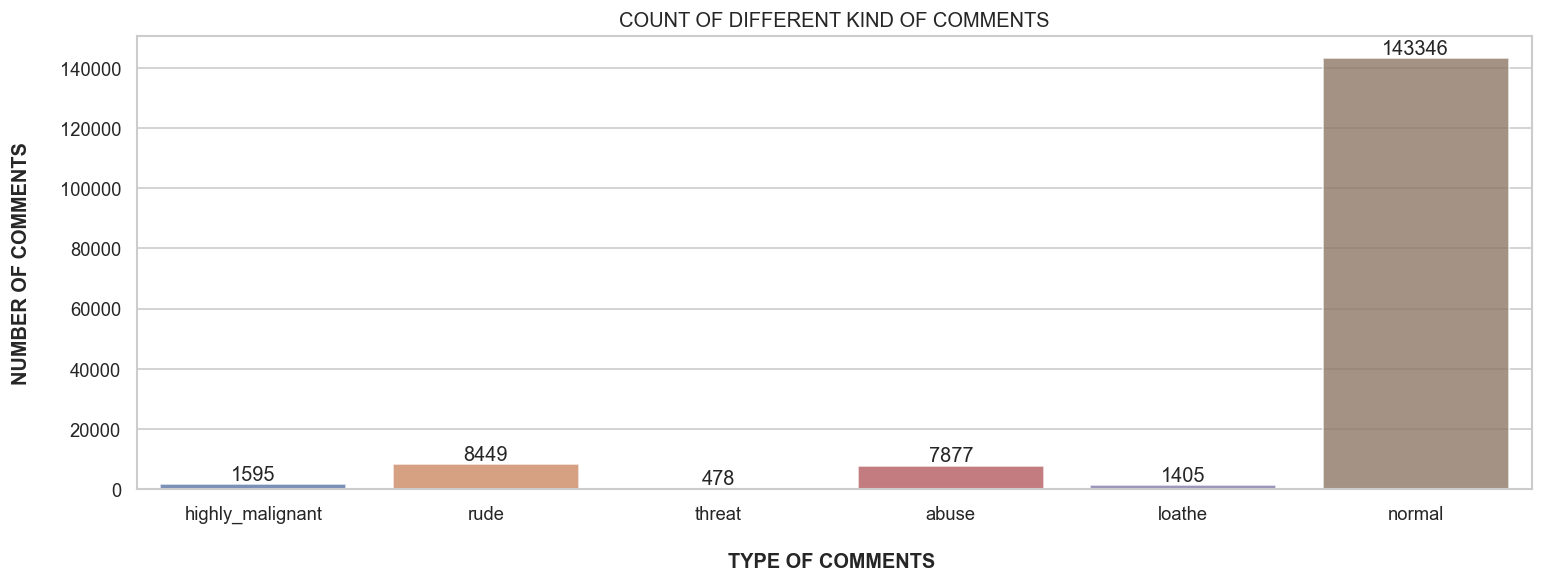

In [20]:
#COUNT OF LABELS
x=cmt.iloc[:,2:-1].sum() #not including comment_text and raw length column
plt.figure(figsize=(15,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("COUNT OF DIFFERENT KIND OF COMMENTS")
plt.ylabel('NUMBER OF COMMENTS\n', fontsize=12,weight='bold')
plt.xlabel('\nTYPE OF COMMENTS ', fontsize=12,weight='bold')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [21]:
#CHECKING THE COUNT OF COMMENTS WITH 1 OR MORE THAN 1 LABELS
summation=cmt.iloc[:,2:-1].sum(axis=1) #not including comment_text and raw length column
vc=summation.value_counts()
vc

1    147303
0      5666
2      4406
3      1780
4       385
5        31
dtype: int64

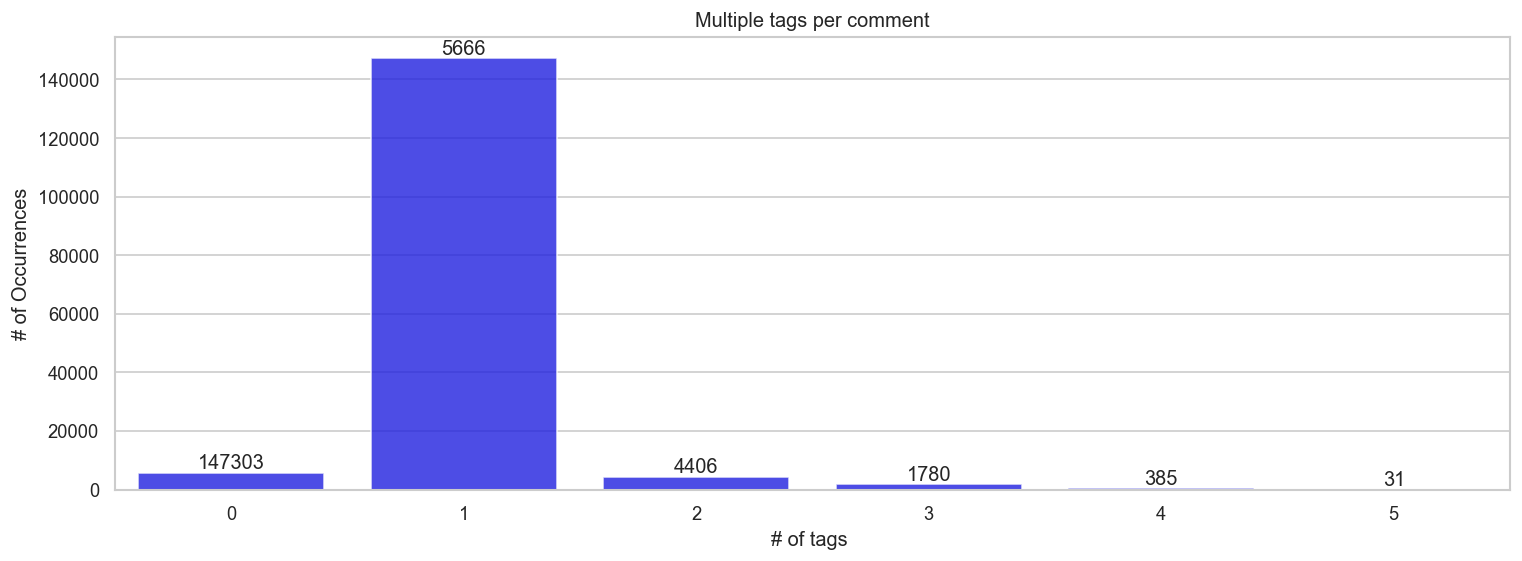

In [22]:
#PLOTTING NUMBERS OF COMMENTS WITH 1 OR MORE THAN 1 LABELS

plt.figure(figsize=(15,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
ax=sns.barplot(x=vc.index, y=vc.values, alpha=0.8,color='blue')
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)
rects = ax.patches
labels = vc.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [23]:
cmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   comment_text      159571 non-null  object
 1   malignant         159571 non-null  int64 
 2   highly_malignant  159571 non-null  int64 
 3   rude              159571 non-null  int64 
 4   threat            159571 non-null  int64 
 5   abuse             159571 non-null  int64 
 6   loathe            159571 non-null  int64 
 7   normal            159571 non-null  int64 
 8   raw length        159571 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 11.0+ MB


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  153164 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [25]:
cmt.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321,394.138847
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226,590.725381
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,96.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,205.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,436.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000


In [26]:
stopwords=['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'yo','nothin','from','bein','u','ok','yup','youve',
           'your','yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','ur','mlm','nbfc',"he's",'ip','ja',"there's",'tyme','yep',\
           'herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','lol','lool','fwiw','argh',"dont","i'll",'utc','too','y','u','r',\
           'doesnt','who','whom','this','that',"that'll",'these','how','these','those','am','is','are','was','were','oh','hay','thanks','ty','wc','ha','hi','d','re',\
           'll','there','someone','say','be','been','being','have','has','had','having','do','does','did','done','doing','a','an','the','even','aww','bye!','bye','e',\
           'f','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after',\
           'above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how',\
           'all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','\
           don',"don't",'should',"should've",'now','d','ll','m','o','re','ve','y','ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",\
           'hadn', "hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",\
           'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't", 'looked', "what's",'although','upright','bit',\
           'right','state',"i've",'much','more',"there's","You've",'got',"i'd",'everything','true','yes','moreover','would','could','like','mr.','but',"i'm",'able',\
           'back','get','still','ought','perhaps','without','away','onto','ive','let','must','see','went','saw','many','whats','id','let','day','never','yet','im','go',\
           'thatll','theyre','came','youll','come','word','noone',"mrs.","now!","then?",'mr','ve','Â Â','january','days','february','march','april','may',\
           'june','july','august','september','october','november','december','everyone','hey','ok','okay','cant','bbq','let','thats','also','time','name',\
           'oh', 'said','asked','anyone','however','wow','daww']

print(len(stopwords))

322


In [27]:
#CREATING A FUNCTION TO PERFORM ASERIES OF OPERATIONS

def preprocess(text):
    processed=[]
    lower=text.lower().replace(r'\n'," ").replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ').replace(r'^http://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
    #converting to lower case and replacing mail id,links by white space
    
    text=lower.replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', ' ')
    #removing \n,large white space and leading_trailing white spaces, numbers by white space
    
    text=lower.replace(r"[^a-zA-Z]+", " ").replace(r"—"," ").replace(r'“', ' ').replace(r'”',' ').replace('’',' ').replace(r'–',' ').replace('«', ' ').replace('»',' ')
    text=text.replace('®',' ').replace('´',' ').replace('·',' ').replace('½',' ').replace('¾',' ').replace('¤',' ')
    #removing special characters by single white space
    
   
   
    punct=text.translate(str.maketrans('', '', p))  #remove punctuation
    digit=punct.translate(str.maketrans('', '', d))       #remove digits if any
    word= wt(digit, "english")
    
    for i in word:
        if i not in stopwords and len(i)>=3 and len(i)<12:
            lemma=porter().stem(wl().lemmatize(i))
           # lemma=wl().lemmatize(i)
            #stem=porter.stem(lemma)
            processed.append(lemma)
    return (" ".join([x for x in processed])).strip()

In [28]:
#TESTING THE FUNCTION CREATED ABOVE
sample=" As much as human rights and ethnic rights should be respected, spray painting every possible detail of unverifiable information\
on the Rohingya, and getting around the verification by claiming that the information was destroyed by an interested party - \
are not valid reasons for having a list of villages where a certain group of people live. There is already a lot of articles on the \
Arakanese people and state that have no concern of the Rohingya but include them for the sake of brotherly respect - this is pushing the\
line a bit far. Rohingyas should be treated fairly - I do not contest that. But articles like this one - are pure self-pitying and clutters \
Wikipedia with absolutely useless information. I wonder when will somebody change the name of the article on Burma/Myanmar on \
wiki to ""Country where the Rohingya are Persecuted"".\nRather, a brief mention of where the Rohingyas reside should be placed if desired\
on the main article on Rakhine state - albeit short and concise, not dump an entire list of names copied directly from some publication.\nWith\
all due respect, this article should be deleted."
print("Original Document: \n",sample)

processed=[]
for word in sample.split(' '):
    processed.append(word)
print('\n',processed)
print("\n\nTokenized and lemmatized document: \n")
print(preprocess(sample))

Original Document: 
  As much as human rights and ethnic rights should be respected, spray painting every possible detail of unverifiable informationon the Rohingya, and getting around the verification by claiming that the information was destroyed by an interested party - are not valid reasons for having a list of villages where a certain group of people live. There is already a lot of articles on the Arakanese people and state that have no concern of the Rohingya but include them for the sake of brotherly respect - this is pushing theline a bit far. Rohingyas should be treated fairly - I do not contest that. But articles like this one - are pure self-pitying and clutters Wikipedia with absolutely useless information. I wonder when will somebody change the name of the article on Burma/Myanmar on wiki to Country where the Rohingya are Persecuted.
Rather, a brief mention of where the Rohingyas reside should be placed if desiredon the main article on Rakhine state - albeit short and conc

In [29]:
%%time
clean = []

for i in cmt.comment_text:
    clean.append(preprocess(i))

Wall time: 3min 8s


In [30]:
print("Length of cleaned text=\t",len(clean))
print(clean[37])

Length of cleaned text=	 159571
pretti warren region born glen fall hospit includ sure qualifi glen fall nativ rachel ray believ actual town lake luzern preced unsign comment ad


In [31]:
#USING THE EXTRACTED FEATURE AS ''comment" also adding an extra column to represent the length of string of the cleaned comments
processed = pd.DataFrame({'comment' : clean })
cmt['comment']= processed

cmt['len of cleaned comment']=cmt['comment'].str.len().astype('int64')
cmt.head(5)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length,comment,len of cleaned comment
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264,explan edit made usernam hardcor metallica fan...,141
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112,match background colour seemingli stuck talk,44
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233,man realli tri edit war guy constantli remov r...,114
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622,make real suggest improv wonder section statis...,250
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67,sir hero chanc rememb page,26


In [32]:
print('Original Length = ',cmt['raw length'].sum())
print('Clean Length =  ', cmt['len of cleaned comment'].sum())
print('Total Reduction = ',cmt['raw length'].sum()-cmt['len of cleaned comment'].sum())

Original Length =  62893130
Clean Length =   29843347
Total Reduction =  33049783


In [33]:
%%time
comments = []

for i in test.comment_text:
    comments.append(preprocess(i))

Wall time: 2min 46s


In [34]:
#USING THE EXTRACTED FEATURE AS ''comment" also adding an extra column to represent the length of string of the cleaned comments
processed = pd.DataFrame({'comment' : comments })
test['comment']= processed
test.head(5)

,comment_text,comment
0,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succes ever hate sad mofuckasi bitc...
1,== From RfC == \n\n The title is fine as it is...,rfc titl fine imo
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sourc zaw ashton lapland
3,":If you have a look back at the source, the in...",look sourc inform updat correct form guess sou...
4,I don't anonymously edit articles at all.,anonym edit articl


#### WORD CLOUDS

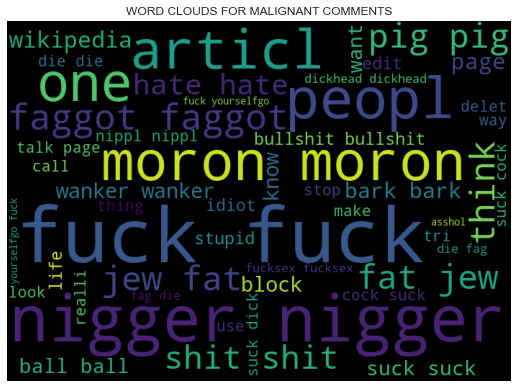

In [35]:
malignant = cmt['comment'][cmt['malignant']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(malignant))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR MALIGNANT COMMENTS')
plt.show()

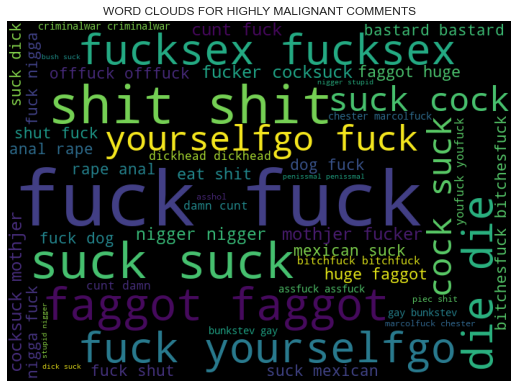

In [36]:
highly_malignant = cmt['comment'][cmt['highly_malignant']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(highly_malignant))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR HIGHLY MALIGNANT COMMENTS')
plt.show()

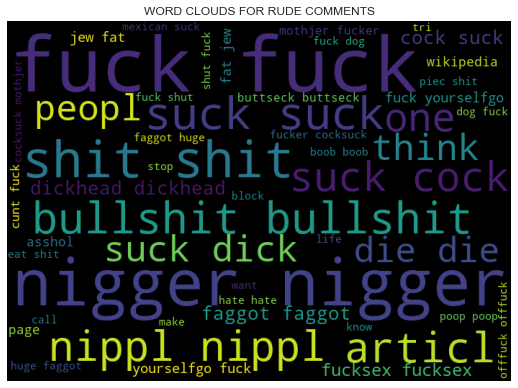

In [37]:
rude = cmt['comment'][cmt['rude']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(rude))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR RUDE COMMENTS')
plt.show()

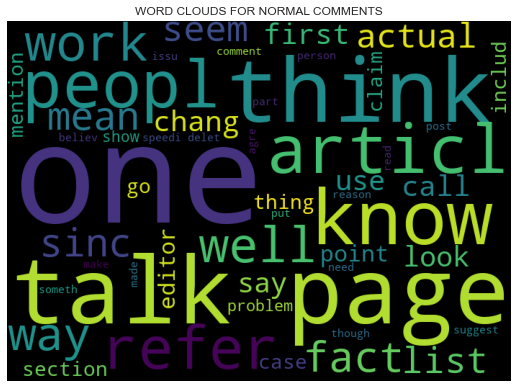

In [38]:
normal = cmt['comment'][cmt['normal']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(normal))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR NORMAL COMMENTS')
plt.show()

# MODELLING 

In [39]:
cmt.sample(4)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length,comment,len of cleaned comment
62824,RE \n\nabout this: (1 2) I politely ask to st...,0,0,0,0,0,0,1,112,polit ask stay talk page thing gracia,37
143810,You and your behaviour at the Paris article. I...,0,0,0,0,0,0,1,377,behaviour pari articl isnt first seen first ta...,159
137765,Ok thanks Ramisses,0,0,0,0,0,0,1,18,ramiss,6
88949,Paradox? Don't you mean conundrum. a paradox i...,0,0,0,0,0,0,1,103,paradox mean conundrum paradox someth thought ...,52


In [40]:
X=cmt.comment
y=cmt.iloc[:,1:-3]

In [41]:
X.head(4)

0    explan edit made usernam hardcor metallica fan...
1         match background colour seemingli stuck talk
2    man realli tri edit war guy constantli remov r...
3    make real suggest improv wonder section statis...
Name: comment, dtype: object

In [42]:
y.head(4)

,malignant,highly_malignant,rude,threat,abuse,loathe,normal
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1


In [43]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=10000,ngram_range=(1,3))

In [44]:
x=tfidf.fit_transform(X).toarray()

In [45]:
#CHECKING THE SELECTED FEATURE NAMES
tfidf.get_feature_names()[1:9]

['abandon', 'abc', 'abid', 'abil', 'aborigin', 'abort', 'abraham', 'abroad']

In [46]:
x_train,x_test,y_train,y_test=tts(x,y,test_size=0.30,random_state=95)

In [47]:
print('shape of x_train:',x_train.shape,'\nshape of x_test:',x_test.shape)

print('shape of y_train:',y_train.shape,'\nshape of y_test:',y_test.shape)

shape of x_train: (111699, 10000) 
shape of x_test: (47872, 10000)
shape of y_train: (111699, 7) 
shape of y_test: (47872, 7)


In [48]:
labels=['malignant','highly_malignant','rude','threat','abuse','loathe','normal']

### LOGISTIC REGRESSION

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9560076871657754

F1 score: 0.7235494880546075

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     43299
           1       0.91      0.60      0.72      4573

    accuracy                           0.96     47872
   macro avg       0.93      0.80      0.85     47872
weighted avg       0.95      0.96      0.95     47872


PRECISION:
 0.9050903119868637

RECALL:
 0.6026678329324294

MEAN SQUARED ERROR:
 0.0439923128342246

ROOT MEAN SQ. ERROR:
 0.20974344527118027

LOG_LOSS: 1.5194454831914117

AUC_ROC Score:
 0.7979966569452096

TPR: [0.         0.00667452 1.        ] 
FPR: [0.         0.60266783 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



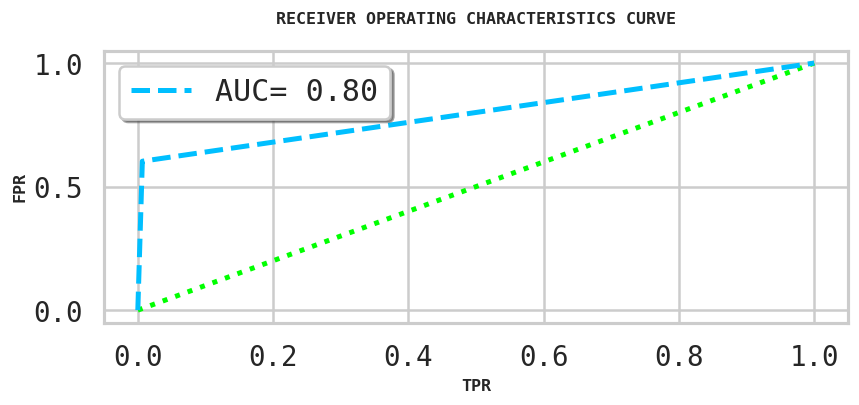





	____________________________________________CONFUSION MATRIX___________________________________________



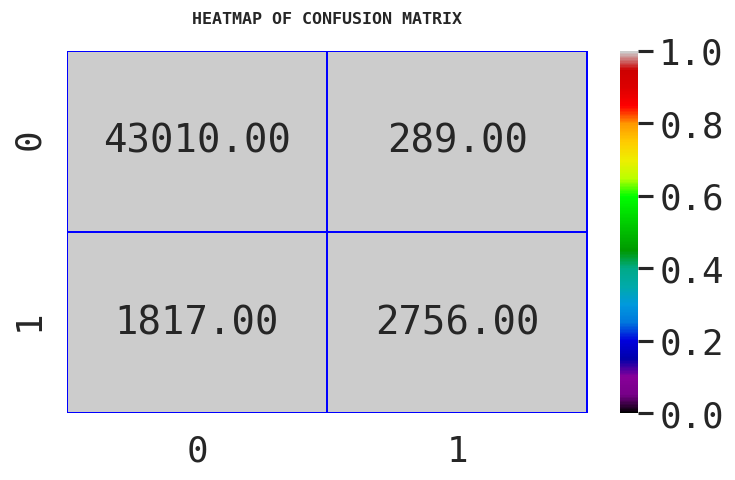



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9903701537433155

F1 score: 0.2670906200317965

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47425
           1       0.46      0.19      0.27       447

    accuracy                           0.99     47872
   macro avg       0.73      0.59      0.63     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.46153846153846156

RECALL:
 0.18791946308724833

MEAN SQUARED ERROR:
 0.009629846256684492

ROOT MEAN SQ. ERROR:
 0.09813178005460052

LOG_LOSS: 0.33260474345341806

AUC_ROC Score:
 0.5929265212115209

TPR: [0.         0.00206642 1.        ] 
FPR: [0.         0.18791946 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



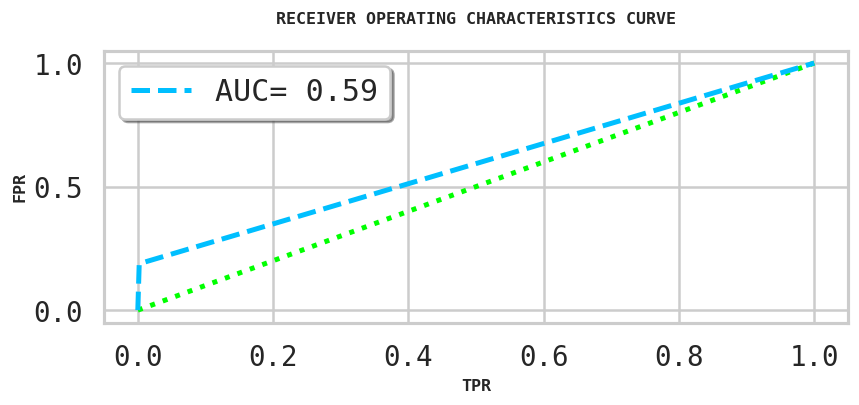





	____________________________________________CONFUSION MATRIX___________________________________________



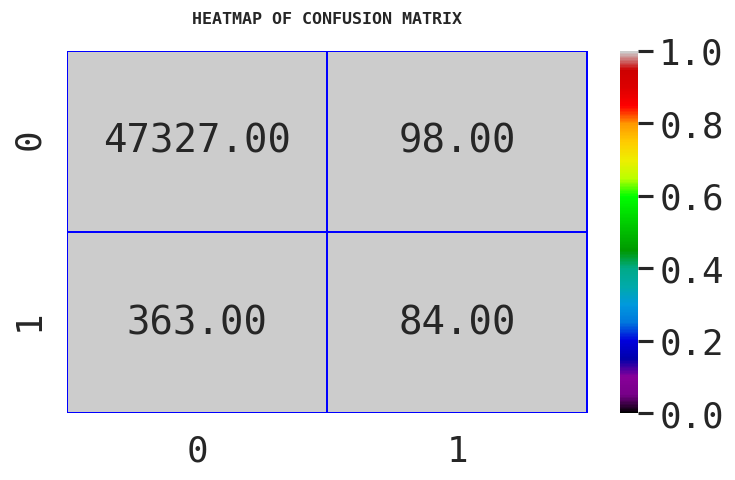



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9774189505347594

F1 score: 0.7461845503639352

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     45359
           1       0.91      0.63      0.75      2513

    accuracy                           0.98     47872
   macro avg       0.95      0.81      0.87     47872
weighted avg       0.98      0.98      0.98     47872


PRECISION:
 0.9100801832760596

RECALL:
 0.6323119777158774

MEAN SQUARED ERROR:
 0.02258104946524064

ROOT MEAN SQ. ERROR:
 0.15026992202447115

LOG_LOSS: 0.779924440585207

AUC_ROC Score:
 0.8144253510572818

TPR: [0.         0.00346128 1.        ] 
FPR: [0.         0.63231198 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



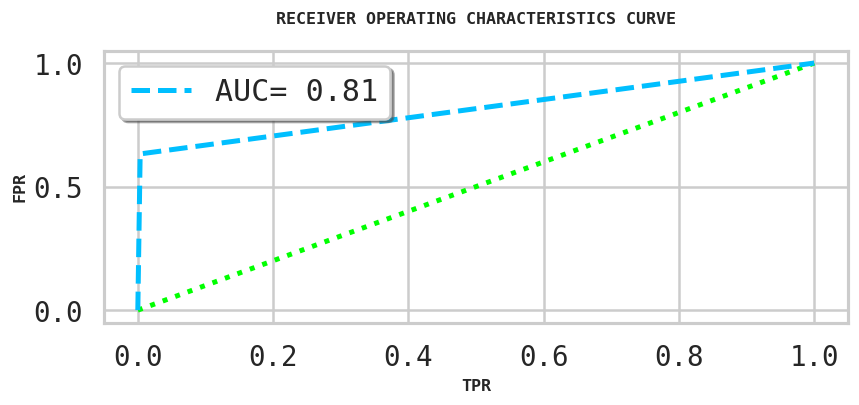





	____________________________________________CONFUSION MATRIX___________________________________________



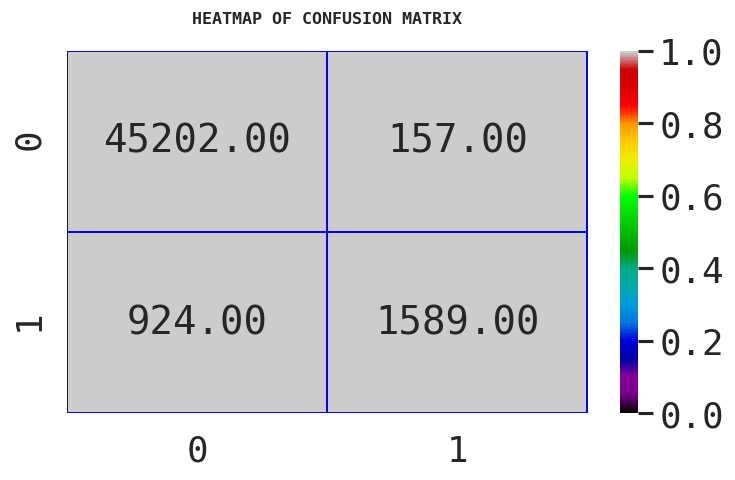



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9972426470588235

F1 score: 0.12000000000000001

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47737
           1       0.60      0.07      0.12       135

    accuracy                           1.00     47872
   macro avg       0.80      0.53      0.56     47872
weighted avg       1.00      1.00      1.00     47872


PRECISION:
 0.6

RECALL:
 0.06666666666666667

MEAN SQUARED ERROR:
 0.0027573529411764708

ROOT MEAN SQ. ERROR:
 0.05251050315105037

LOG_LOSS: 0.09523569689406831

AUC_ROC Score:
 0.5332704889987501

TPR: [0.00000000e+00 1.25688669e-04 1.00000000e+00] 
FPR: [0.         0.06666667 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



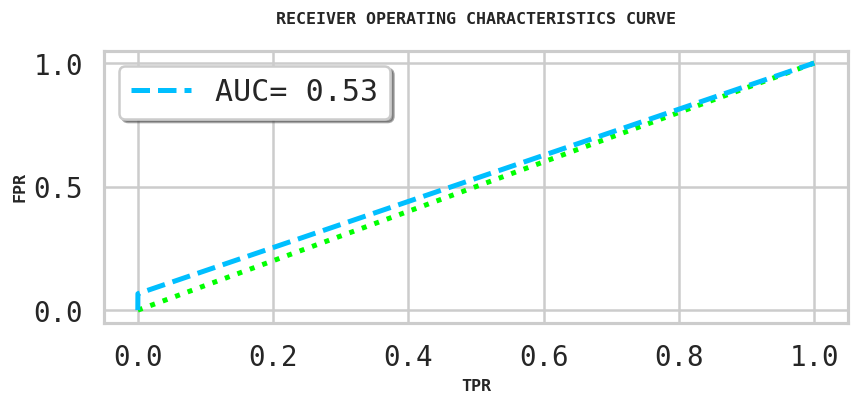





	____________________________________________CONFUSION MATRIX___________________________________________



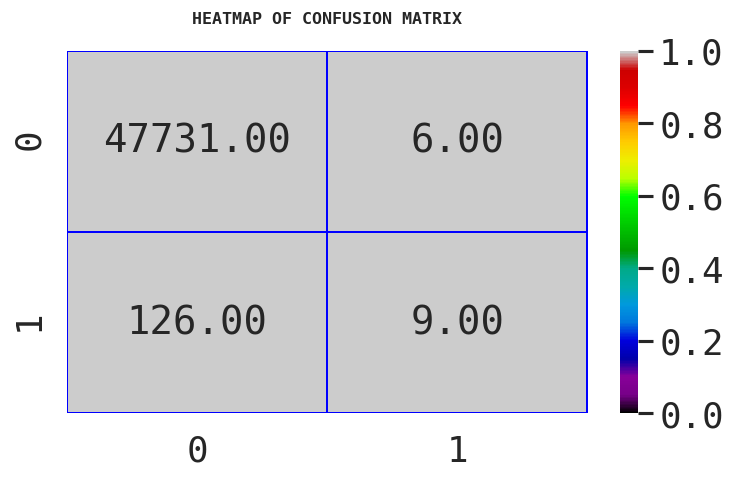



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9701495655080213

F1 score: 0.6226564562978611

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     45531
           1       0.82      0.50      0.62      2341

    accuracy                           0.97     47872
   macro avg       0.90      0.75      0.80     47872
weighted avg       0.97      0.97      0.97     47872


PRECISION:
 0.8153526970954357

RECALL:
 0.503630926954293

MEAN SQUARED ERROR:
 0.02985043449197861

ROOT MEAN SQ. ERROR:
 0.1727727828449221

LOG_LOSS: 1.0310019418624932

AUC_ROC Score:
 0.7488833952159618

TPR: [0.         0.00586414 1.        ] 
FPR: [0.         0.50363093 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



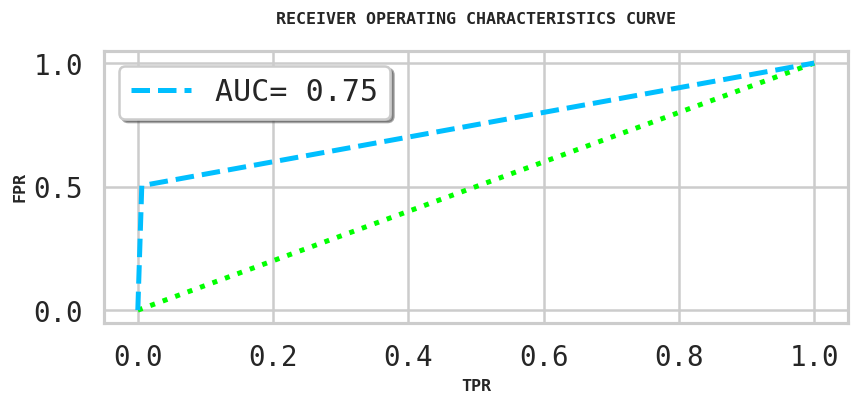





	____________________________________________CONFUSION MATRIX___________________________________________



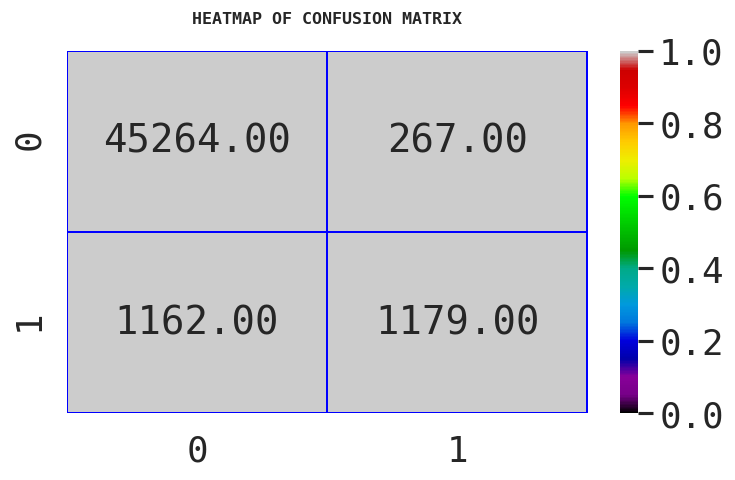



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9918950534759359

F1 score: 0.26235741444866917

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47448
           1       0.68      0.16      0.26       424

    accuracy                           0.99     47872
   macro avg       0.83      0.58      0.63     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.6764705882352942

RECALL:
 0.16273584905660377

MEAN SQUARED ERROR:
 0.00810494652406417

ROOT MEAN SQ. ERROR:
 0.09002747649503551

LOG_LOSS: 0.2799354868804434

AUC_ROC Score:
 0.5810201754134814

TPR: [0.0000000e+00 6.9549823e-04 1.0000000e+00] 
FPR: [0.         0.16273585 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



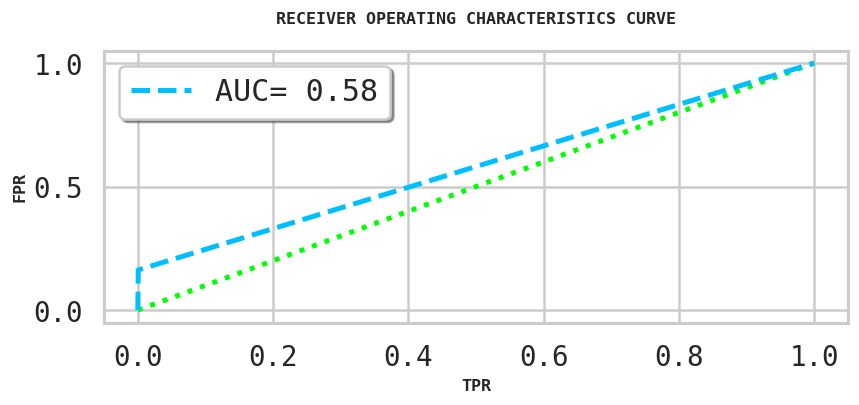





	____________________________________________CONFUSION MATRIX___________________________________________



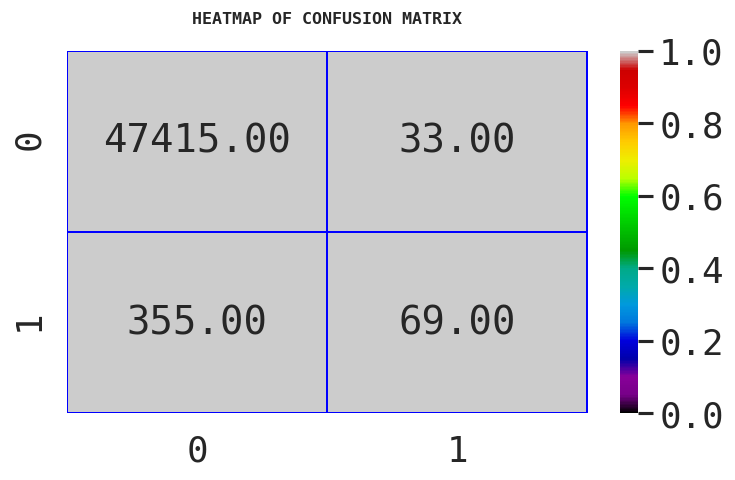



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9554645721925134

F1 score: 0.9756754289886821

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.92      0.62      0.74      4844
           1       0.96      0.99      0.98     43028

    accuracy                           0.96     47872
   macro avg       0.94      0.80      0.86     47872
weighted avg       0.95      0.96      0.95     47872


PRECISION:
 0.9582698341550874

RECALL:
 0.9937250162684763

MEAN SQUARED ERROR:
 0.04453542780748663

ROOT MEAN SQ. ERROR:
 0.2110341863478205

LOG_LOSS: 1.538230283346521

AUC_ROC Score:
 0.8046659763423305

TPR: [0.         0.38439306 1.        ] 
FPR: [0.         0.99372502 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



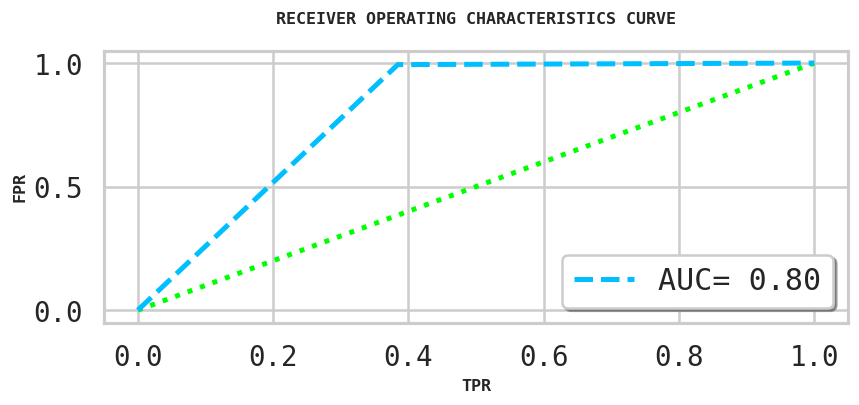





	____________________________________________CONFUSION MATRIX___________________________________________



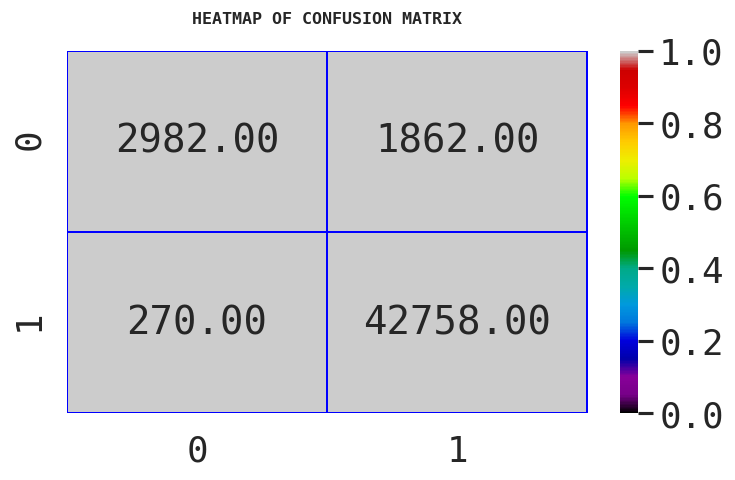

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.723549,0.956008,0.905090,0.602668,0.209743,0.043992,0.797997,1.519445
1,highly_malignant,0.267091,0.990370,0.461538,0.187919,0.098132,0.009630,0.592927,0.332605
2,rude,0.746185,0.977419,0.910080,0.632312,0.150270,0.022581,0.814425,0.779924
3,threat,0.120000,0.997243,0.600000,0.066667,0.052511,0.002757,0.533270,0.095236
4,abuse,0.622656,0.970150,0.815353,0.503631,0.172773,0.029850,0.748883,1.031002
5,loathe,0.262357,0.991895,0.676471,0.162736,0.090027,0.008105,0.581020,0.279935
6,normal,0.975675,0.955465,0.958270,0.993725,0.211034,0.044535,0.804666,1.538230


In [49]:
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    LogReg_pipeline.fit(x_train, y_train[category])
    pred = LogReg_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

logi_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
logi_results.style.set_properties(**{'background-color':'midnightblue','color': 'lime','border-color': 'darkorange'})                                

### PASSIVE AGGRESSIVE CLASSIFIER

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9164647393048129

F1 score: 0.649179752609878

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.93      0.95     43299
           1       0.54      0.81      0.65      4573

    accuracy                           0.92     47872
   macro avg       0.76      0.87      0.80     47872
weighted avg       0.94      0.92      0.92     47872


PRECISION:
 0.5420451215939056

RECALL:
 0.8090968729499235

MEAN SQUARED ERROR:
 0.08353526069518717

ROOT MEAN SQ. ERROR:
 0.28902467142994415

LOG_LOSS: 2.885257903258996

AUC_ROC Score:
 0.8684506051162699

TPR: [0.         0.07219566 1.        ] 
FPR: [0.         0.80909687 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



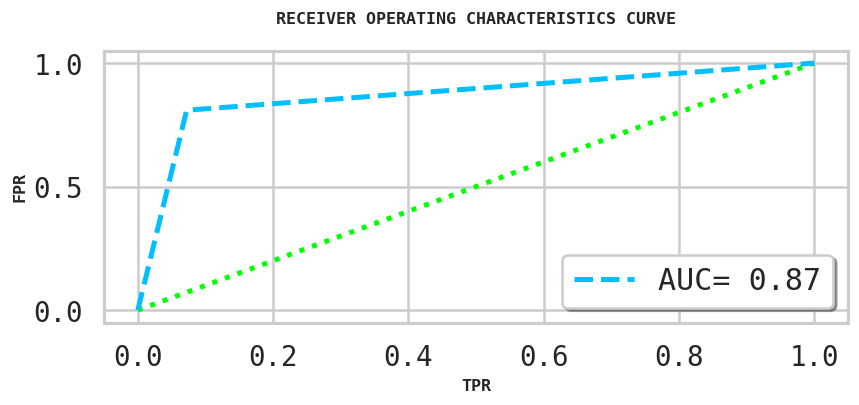





	____________________________________________CONFUSION MATRIX___________________________________________



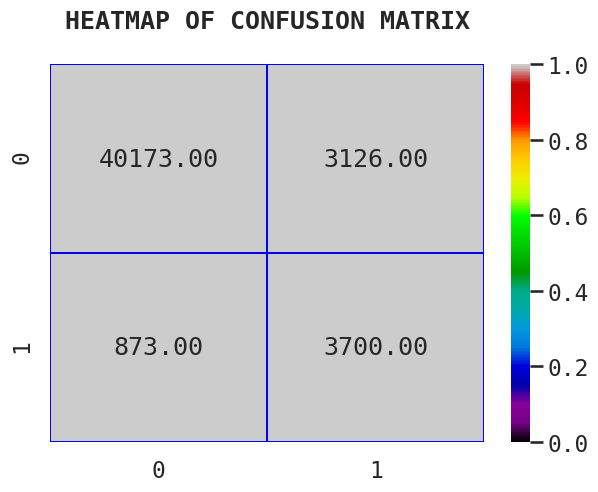



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9898897058823529

F1 score: 0.3546666666666667

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47425
           1       0.44      0.30      0.35       447

    accuracy                           0.99     47872
   macro avg       0.72      0.65      0.67     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.4389438943894389

RECALL:
 0.2975391498881432

MEAN SQUARED ERROR:
 0.01011029411764706

ROOT MEAN SQ. ERROR:
 0.10054995831748047

LOG_LOSS: 0.34920002729570415

AUC_ROC Score:
 0.6469772713067495

TPR: [0.         0.00358461 1.        ] 
FPR: [0.         0.29753915 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



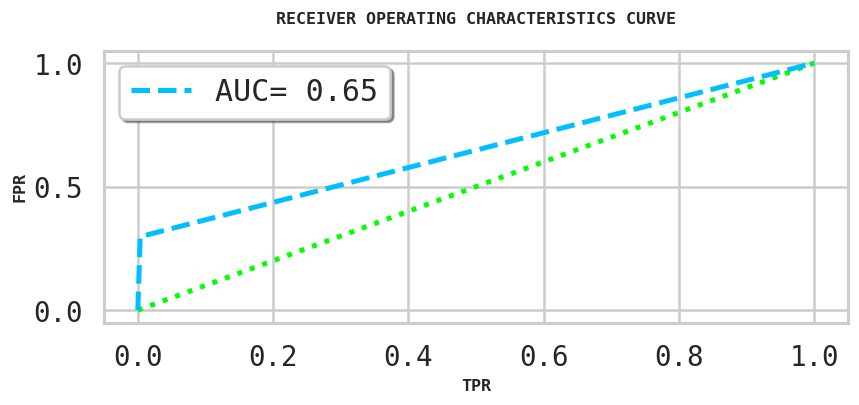





	____________________________________________CONFUSION MATRIX___________________________________________



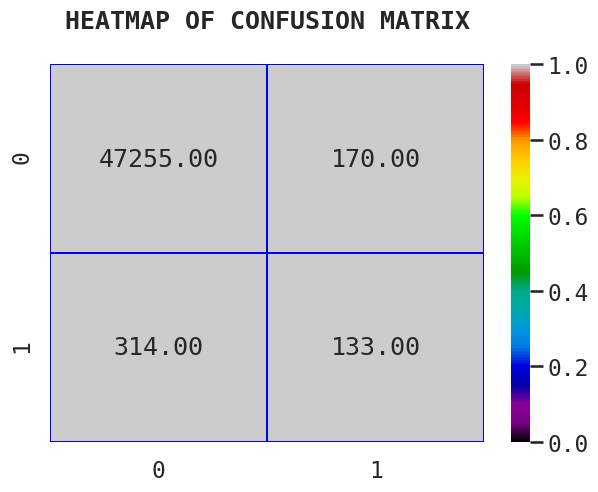



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9677055481283422

F1 score: 0.715599705665931

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     45359
           1       0.67      0.77      0.72      2513

    accuracy                           0.97     47872
   macro avg       0.83      0.88      0.85     47872
weighted avg       0.97      0.97      0.97     47872


PRECISION:
 0.6654122476907287

RECALL:
 0.7739753282928771

MEAN SQUARED ERROR:
 0.032294451871657755

ROOT MEAN SQ. ERROR:
 0.17970657158728992

LOG_LOSS: 1.1154271873499892

AUC_ROC Score:
 0.8762070031971231

TPR: [0.         0.02156132 1.        ] 
FPR: [0.         0.77397533 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



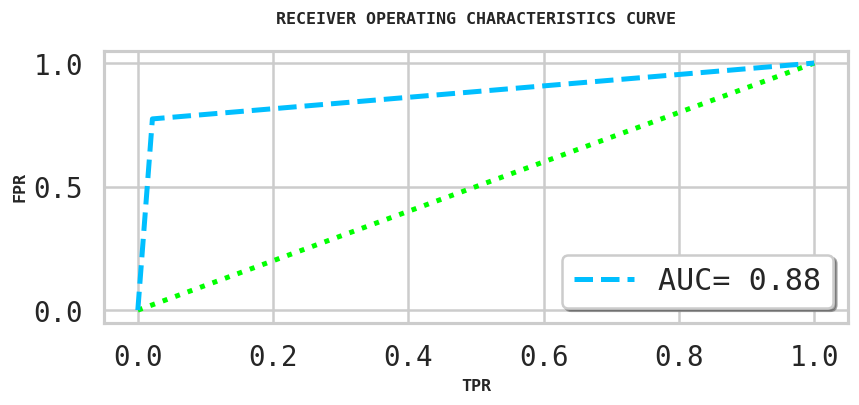





	____________________________________________CONFUSION MATRIX___________________________________________



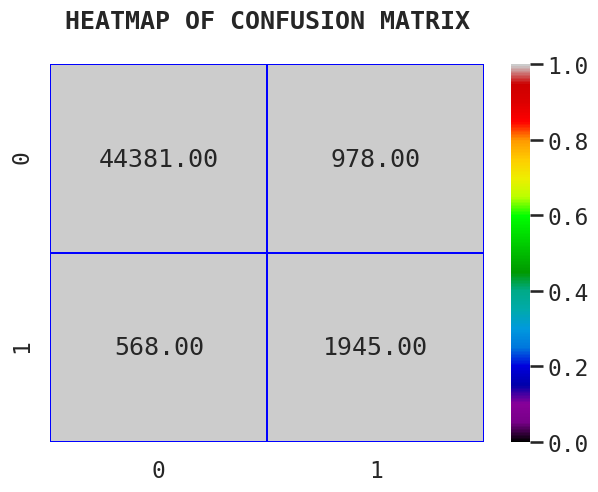



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9971382018716578

F1 score: 0.3251231527093596

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47737
           1       0.49      0.24      0.33       135

    accuracy                           1.00     47872
   macro avg       0.74      0.62      0.66     47872
weighted avg       1.00      1.00      1.00     47872


PRECISION:
 0.4852941176470588

RECALL:
 0.24444444444444444

MEAN SQUARED ERROR:
 0.002861798128342246

ROOT MEAN SQ. ERROR:
 0.05349577673370344

LOG_LOSS: 0.09884359024091048

AUC_ROC Score:
 0.6218556302704867

TPR: [0.00000000e+00 7.33183903e-04 1.00000000e+00] 
FPR: [0.         0.24444444 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



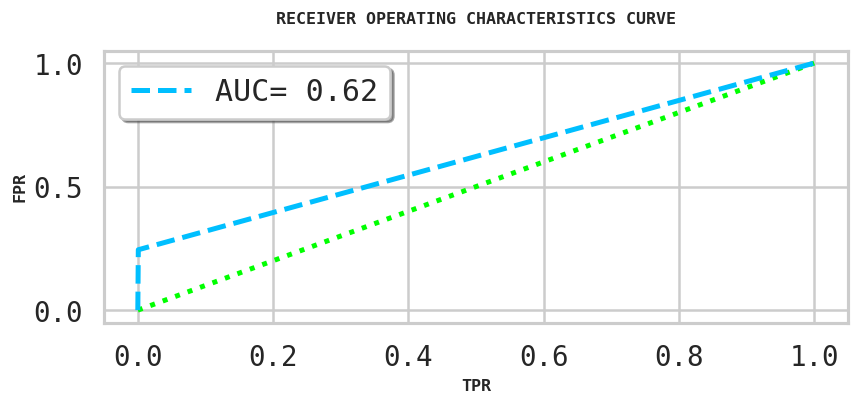





	____________________________________________CONFUSION MATRIX___________________________________________



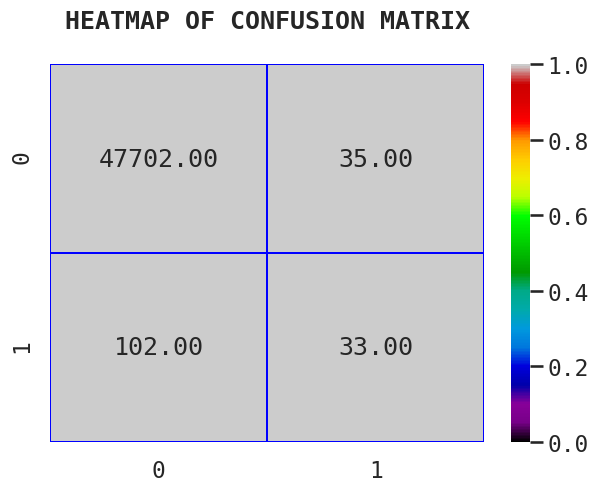



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9617939505347594

F1 score: 0.6130738311825683

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     45531
           1       0.61      0.62      0.61      2341

    accuracy                           0.96     47872
   macro avg       0.79      0.80      0.80     47872
weighted avg       0.96      0.96      0.96     47872


PRECISION:
 0.607292539815591

RECALL:
 0.618966253737719

MEAN SQUARED ERROR:
 0.038206049465240643

ROOT MEAN SQ. ERROR:
 0.19546367812266463

LOG_LOSS: 1.3196058499557939

AUC_ROC Score:
 0.7991934341320428

TPR: [0.         0.02057939 1.        ] 
FPR: [0.         0.61896625 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



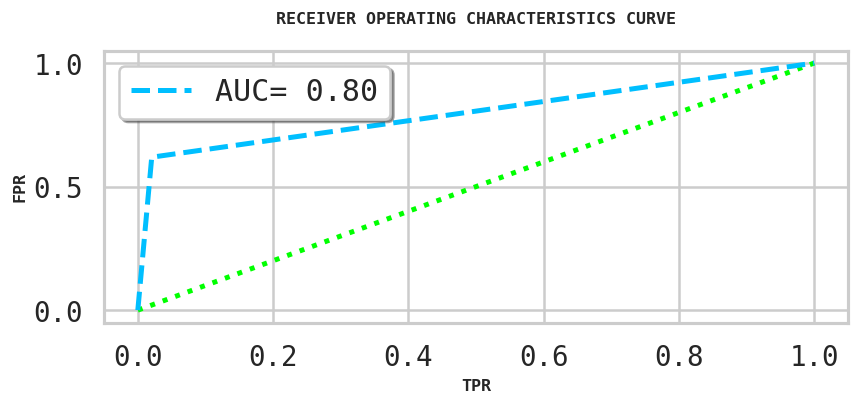





	____________________________________________CONFUSION MATRIX___________________________________________



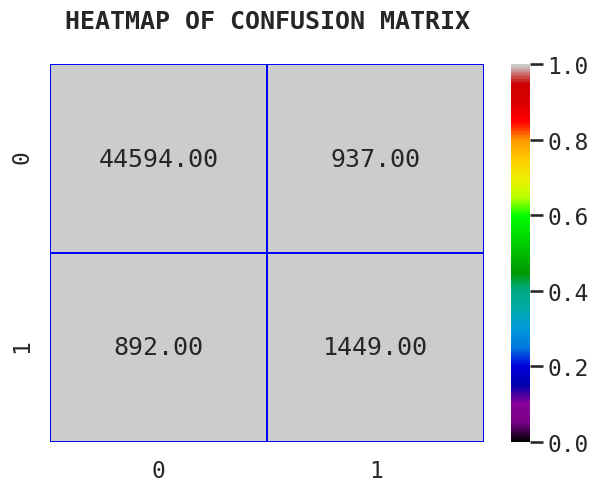



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9901821524064172

F1 score: 0.4337349397590362

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47448
           1       0.44      0.42      0.43       424

    accuracy                           0.99     47872
   macro avg       0.72      0.71      0.71     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.4433497536945813

RECALL:
 0.42452830188679247

MEAN SQUARED ERROR:
 0.009817847593582887

ROOT MEAN SQ. ERROR:
 0.09908505232164379

LOG_LOSS: 0.33910021755153935

AUC_ROC Score:
 0.7098825963994745

TPR: [0.         0.00476311 1.        ] 
FPR: [0.        0.4245283 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



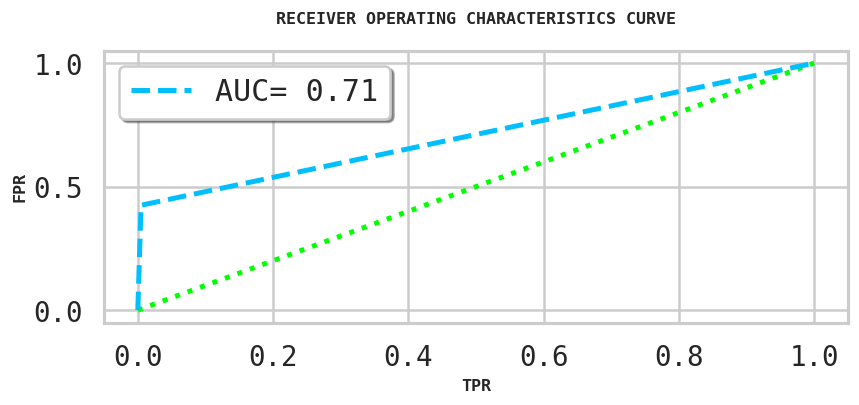





	____________________________________________CONFUSION MATRIX___________________________________________



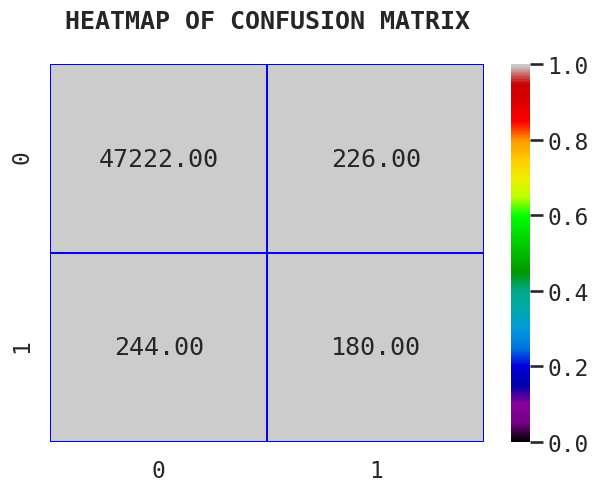



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9479027406417112

F1 score: 0.9710927720339375

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.75      0.72      0.74      4844
           1       0.97      0.97      0.97     43028

    accuracy                           0.95     47872
   macro avg       0.86      0.85      0.85     47872
weighted avg       0.95      0.95      0.95     47872


PRECISION:
 0.9686228264890862

RECALL:
 0.9735753462861393

MEAN SQUARED ERROR:
 0.05209725935828877

ROOT MEAN SQ. ERROR:
 0.228248240646645

LOG_LOSS: 1.7993982574912275

AUC_ROC Score:
 0.8467174832173884

TPR: [0.         0.28014038 1.        ] 
FPR: [0.         0.97357535 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



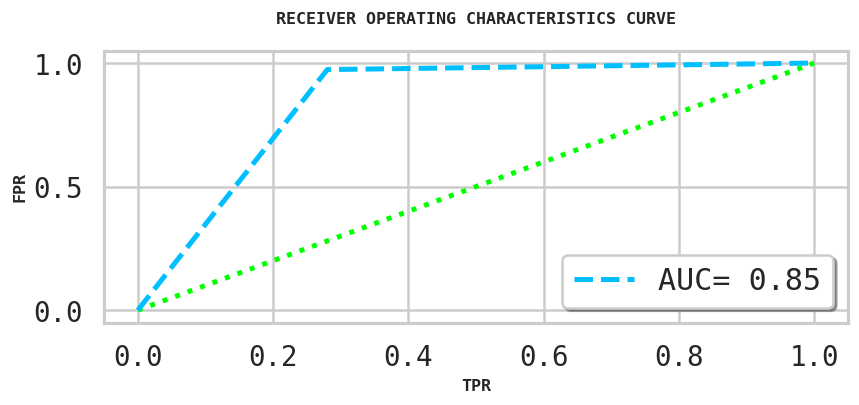





	____________________________________________CONFUSION MATRIX___________________________________________



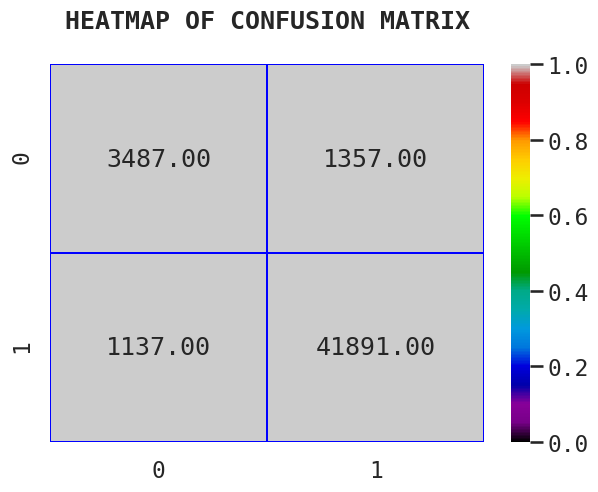

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.649180,0.916465,0.542045,0.809097,0.289025,0.083535,0.868451,2.885258
1,highly_malignant,0.354667,0.989890,0.438944,0.297539,0.100550,0.010110,0.646977,0.349200
2,rude,0.715600,0.967706,0.665412,0.773975,0.179707,0.032294,0.876207,1.115427
3,threat,0.325123,0.997138,0.485294,0.244444,0.053496,0.002862,0.621856,0.098844
4,abuse,0.613074,0.961794,0.607293,0.618966,0.195464,0.038206,0.799193,1.319606
5,loathe,0.433735,0.990182,0.443350,0.424528,0.099085,0.009818,0.709883,0.339100
6,normal,0.971093,0.947903,0.968623,0.973575,0.228248,0.052097,0.846717,1.799398


In [50]:
pac_pipeline = Pipeline([('clf', OneVsRestClassifier(PassiveAggressiveClassifier(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    pac_pipeline.fit(x_train, y_train[category])
    pred = pac_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(7,5),dpi=100)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

pac_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
pac_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

### MULTINOMIAL NB

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.947464070855615

F1 score: 0.6406629518502643

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     43299
           1       0.92      0.49      0.64      4573

    accuracy                           0.95     47872
   macro avg       0.94      0.74      0.81     47872
weighted avg       0.95      0.95      0.94     47872


PRECISION:
 0.9241549876339654

RECALL:
 0.49026897004154824

MEAN SQUARED ERROR:
 0.05253592914438503

ROOT MEAN SQ. ERROR:
 0.22920717515903605

LOG_LOSS: 1.8145297827357862

AUC_ROC Score:
 0.7430097246336982

TPR: [0.         0.00424952 1.        ] 
FPR: [0.         0.49026897 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



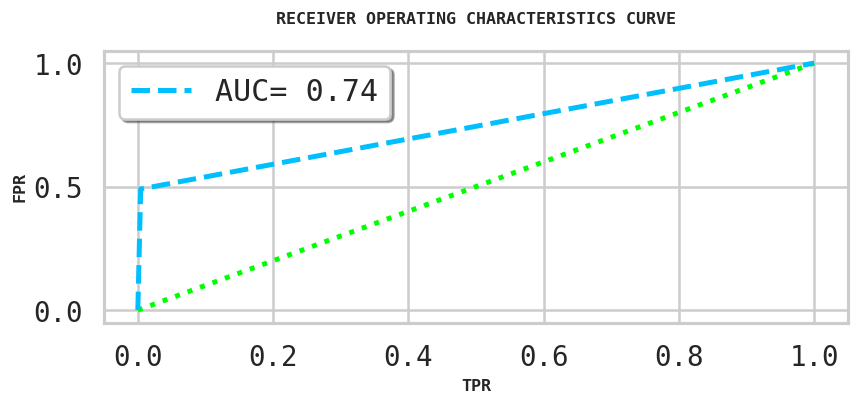





	____________________________________________CONFUSION MATRIX___________________________________________



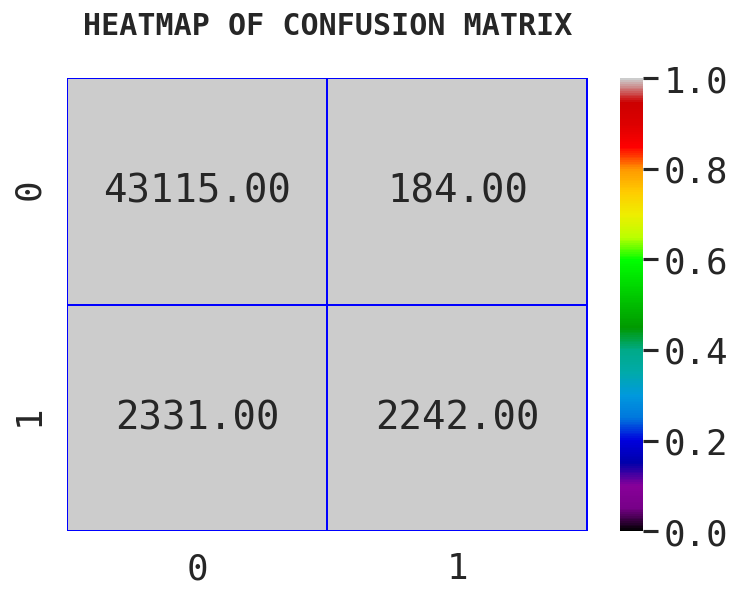



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9894510360962567

F1 score: 0.24287856071964017

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47425
           1       0.37      0.18      0.24       447

    accuracy                           0.99     47872
   macro avg       0.68      0.59      0.62     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.36818181818181817

RECALL:
 0.18120805369127516

MEAN SQUARED ERROR:
 0.010548963903743316

ROOT MEAN SQ. ERROR:
 0.10270814915936961

LOG_LOSS: 0.36435062716144584

AUC_ROC Score:
 0.5891385550480626

TPR: [0.         0.00293094 1.        ] 
FPR: [0.         0.18120805 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



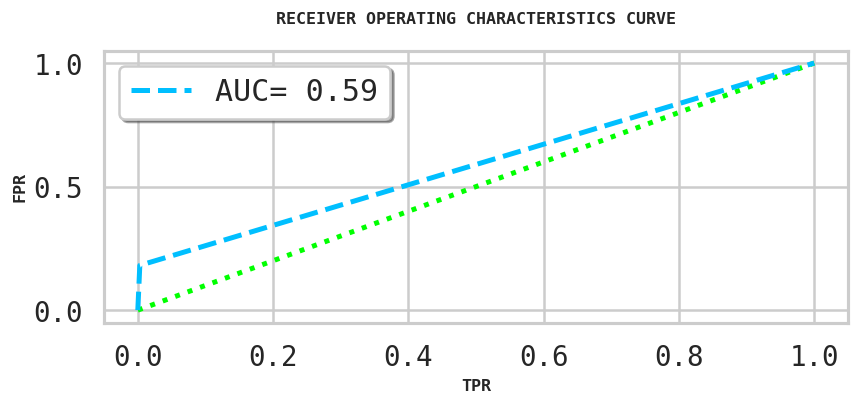





	____________________________________________CONFUSION MATRIX___________________________________________



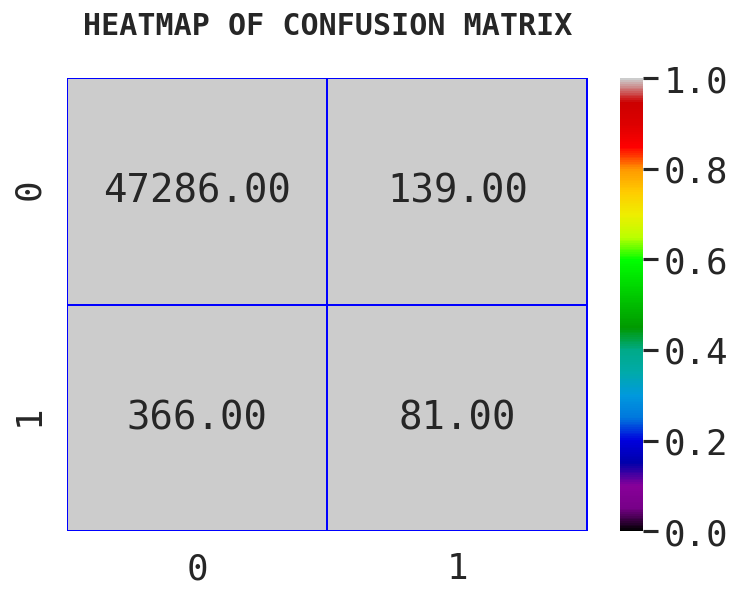



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9704420120320856

F1 score: 0.6398574700941715

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     45359
           1       0.89      0.50      0.64      2513

    accuracy                           0.97     47872
   macro avg       0.93      0.75      0.81     47872
weighted avg       0.97      0.97      0.97     47872


PRECISION:
 0.8877118644067796

RECALL:
 0.5001989653800238

MEAN SQUARED ERROR:
 0.029557987967914437

ROOT MEAN SQ. ERROR:
 0.17192436699873126

LOG_LOSS: 1.0208993928557415

AUC_ROC Score:
 0.7483467985479453

TPR: [0.         0.00350537 1.        ] 
FPR: [0.         0.50019897 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



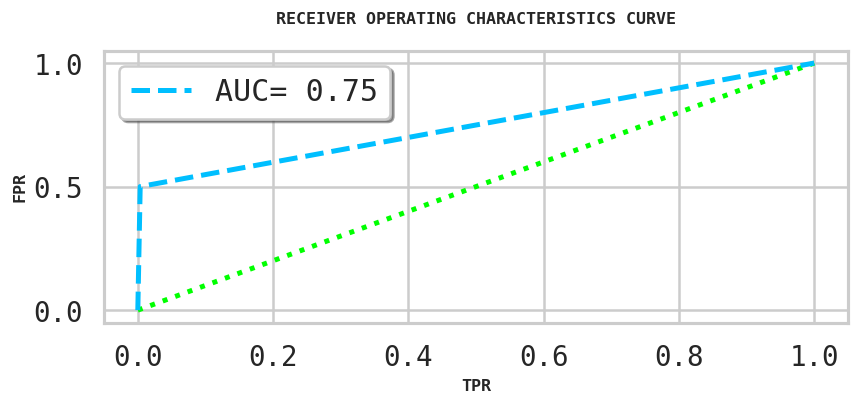





	____________________________________________CONFUSION MATRIX___________________________________________



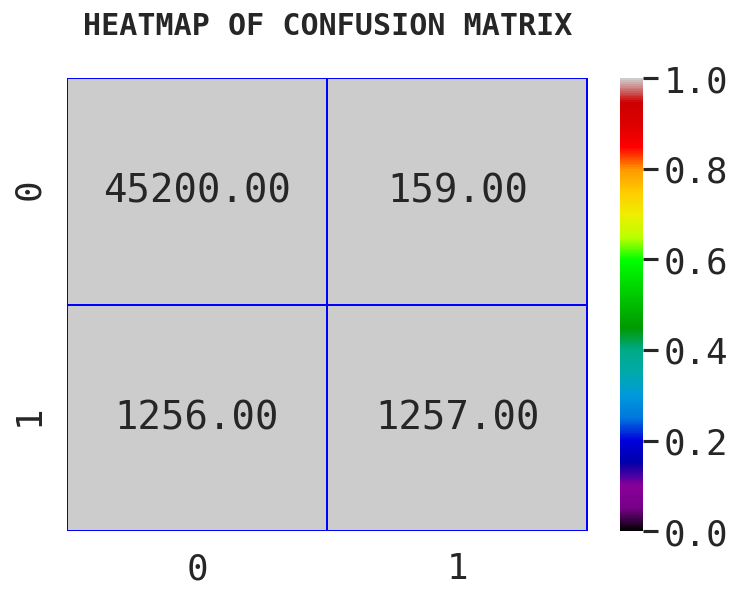



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9955715240641712

F1 score: 0.027522935779816515

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47737
           1       0.04      0.02      0.03       135

    accuracy                           1.00     47872
   macro avg       0.52      0.51      0.51     47872
weighted avg       0.99      1.00      1.00     47872


PRECISION:
 0.03614457831325301

RECALL:
 0.022222222222222223

MEAN SQUARED ERROR:
 0.004428475935828877

ROOT MEAN SQ. ERROR:
 0.06654679508307577

LOG_LOSS: 0.15295547634348947

AUC_ROC Score:
 0.5102731866500013

TPR: [0.         0.00167585 1.        ] 
FPR: [0.         0.02222222 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



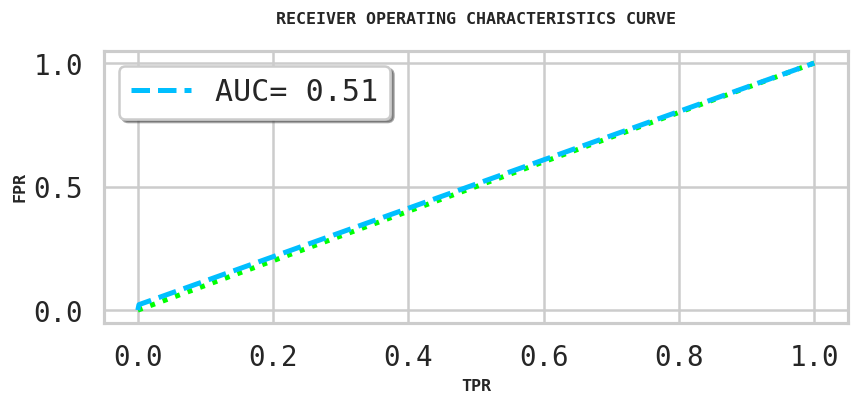





	____________________________________________CONFUSION MATRIX___________________________________________



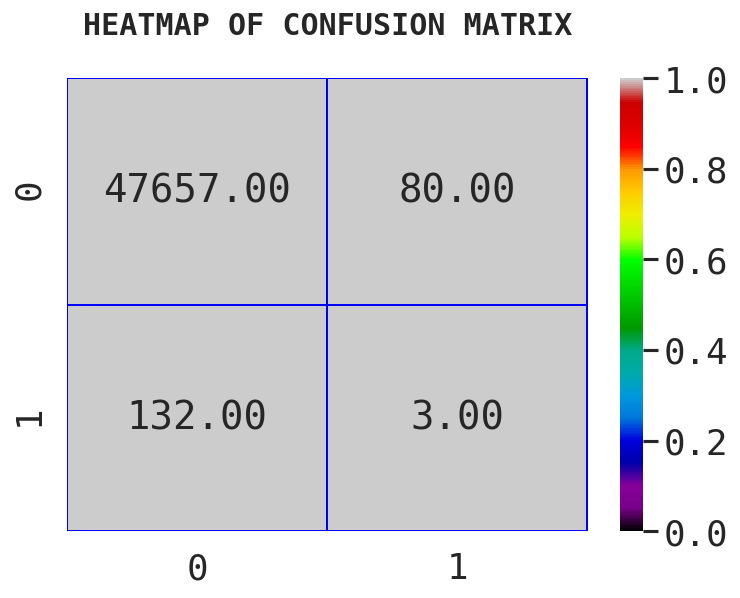



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9663477606951871

F1 score: 0.5424595285430275

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     45531
           1       0.81      0.41      0.54      2341

    accuracy                           0.97     47872
   macro avg       0.89      0.70      0.76     47872
weighted avg       0.96      0.97      0.96     47872


PRECISION:
 0.809322033898305

RECALL:
 0.40794532251174714

MEAN SQUARED ERROR:
 0.033652239304812835

ROOT MEAN SQ. ERROR:
 0.18344546684181878

LOG_LOSS: 1.1623109266716023

AUC_ROC Score:
 0.7015018172155494

TPR: [0.         0.00494169 1.        ] 
FPR: [0.         0.40794532 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



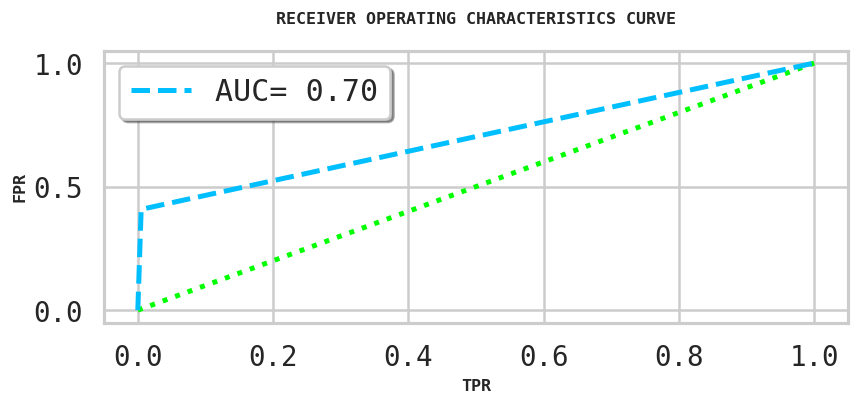





	____________________________________________CONFUSION MATRIX___________________________________________



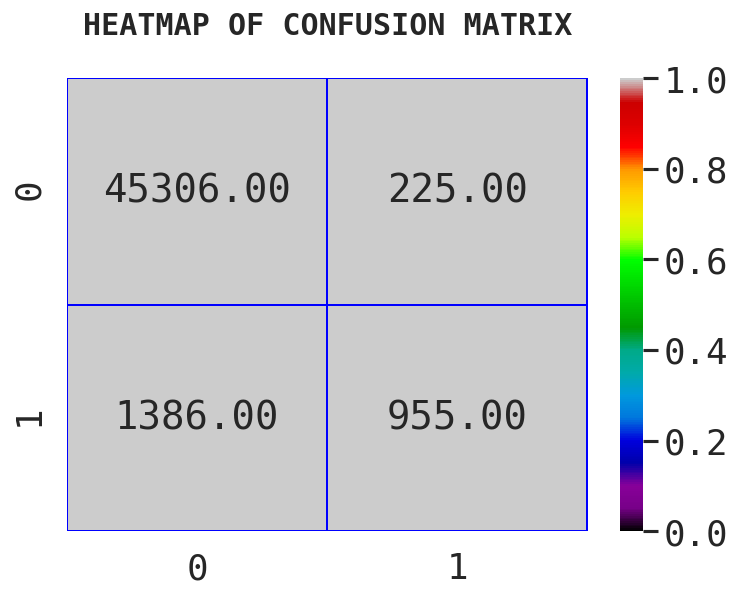



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9893257018716578

F1 score: 0.09236234458259326

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47448
           1       0.19      0.06      0.09       424

    accuracy                           0.99     47872
   macro avg       0.59      0.53      0.54     47872
weighted avg       0.98      0.99      0.99     47872


PRECISION:
 0.18705035971223022

RECALL:
 0.06132075471698113

MEAN SQUARED ERROR:
 0.010674298128342245

ROOT MEAN SQ. ERROR:
 0.10331649494801033

LOG_LOSS: 0.368679083646161

AUC_ROC Score:
 0.5294696000865297

TPR: [0.         0.00238155 1.        ] 
FPR: [0.         0.06132075 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



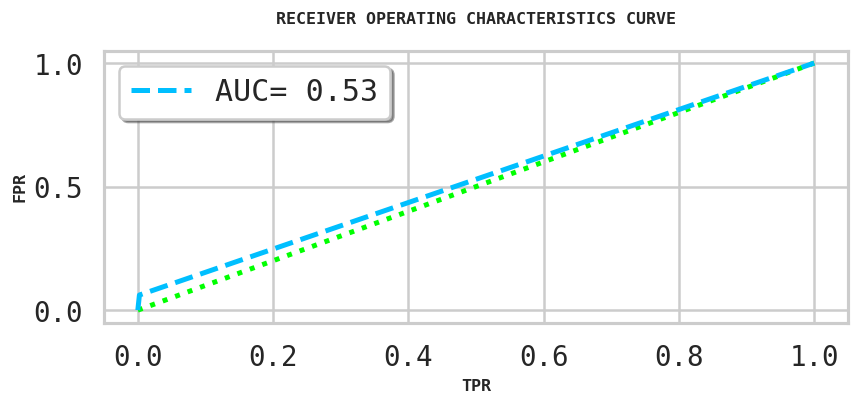





	____________________________________________CONFUSION MATRIX___________________________________________



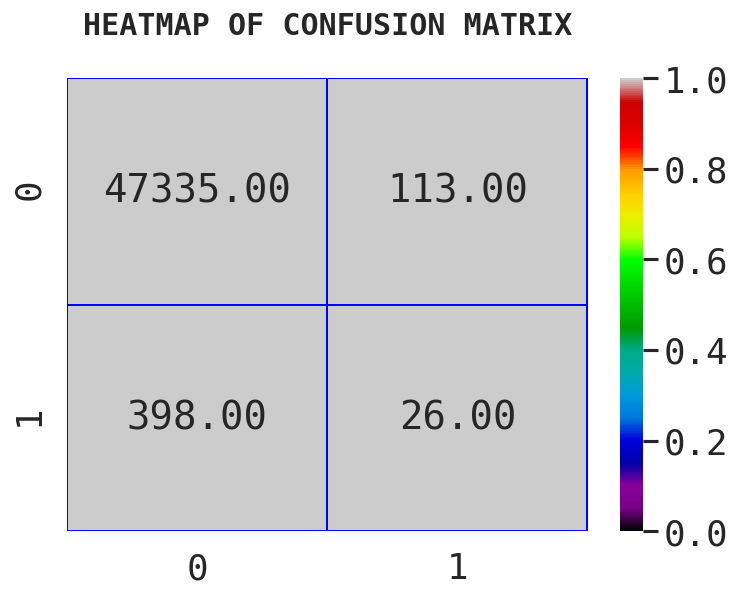



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9464405080213903

F1 score: 0.9709599963756627

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.94      0.50      0.66      4844
           1       0.95      1.00      0.97     43028

    accuracy                           0.95     47872
   macro avg       0.94      0.75      0.81     47872
weighted avg       0.95      0.95      0.94     47872


PRECISION:
 0.9469777306468717

RECALL:
 0.9961885284001115

MEAN SQUARED ERROR:
 0.053559491978609625

ROOT MEAN SQ. ERROR:
 0.23142923751896524

LOG_LOSS: 1.8499194040437728

AUC_ROC Score:
 0.7503651147368022

TPR: [0.        0.4954583 1.       ] 
FPR: [0.         0.99618853 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



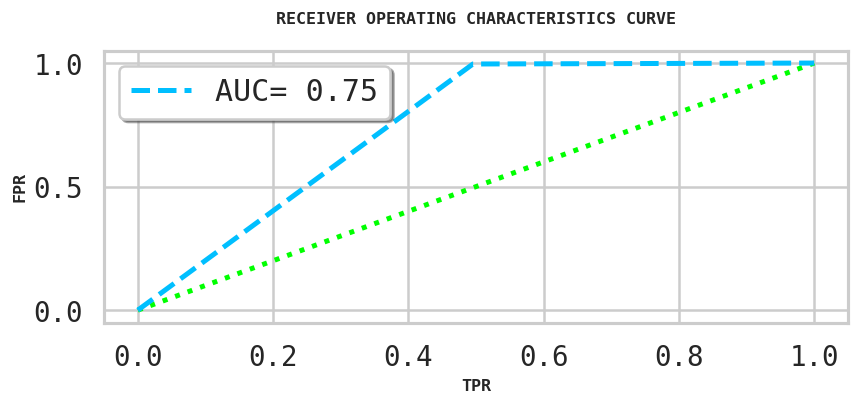





	____________________________________________CONFUSION MATRIX___________________________________________



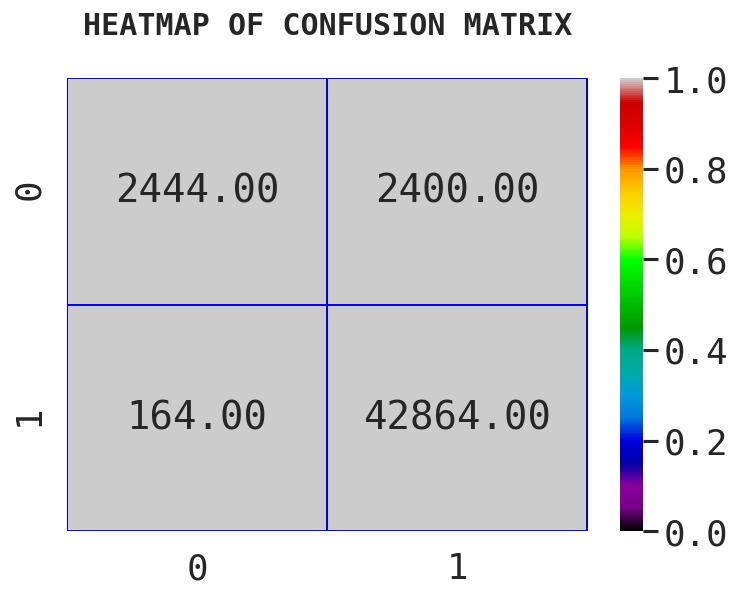

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.640663,0.947464,0.924155,0.490269,0.229207,0.052536,0.743010,1.814530
1,highly_malignant,0.242879,0.989451,0.368182,0.181208,0.102708,0.010549,0.589139,0.364351
2,rude,0.639857,0.970442,0.887712,0.500199,0.171924,0.029558,0.748347,1.020899
3,threat,0.027523,0.995572,0.036145,0.022222,0.066547,0.004428,0.510273,0.152955
4,abuse,0.542460,0.966348,0.809322,0.407945,0.183445,0.033652,0.701502,1.162311
5,loathe,0.092362,0.989326,0.187050,0.061321,0.103316,0.010674,0.529470,0.368679
6,normal,0.970960,0.946441,0.946978,0.996189,0.231429,0.053559,0.750365,1.849919


In [51]:
MNB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    MNB_pipeline.fit(x_train, y_train[category])
    pred = MNB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,5),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

mnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
mnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

### COMPLEMENT NB

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.8845462901069518

F1 score: 0.5903801971392574

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93     43299
           1       0.45      0.87      0.59      4573

    accuracy                           0.88     47872
   macro avg       0.72      0.88      0.76     47872
weighted avg       0.93      0.88      0.90     47872


PRECISION:
 0.44652466367713006

RECALL:
 0.8709818499890662

MEAN SQUARED ERROR:
 0.11545370989304812

ROOT MEAN SQ. ERROR:
 0.33978479938491674

LOG_LOSS: 3.98771233178443

AUC_ROC Score:
 0.8784803704782627

TPR: [0.         0.11402111 1.        ] 
FPR: [0.         0.87098185 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



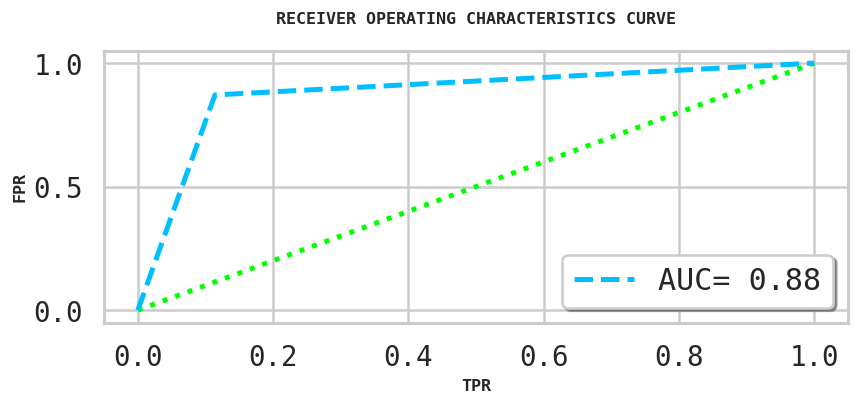





	____________________________________________CONFUSION MATRIX___________________________________________



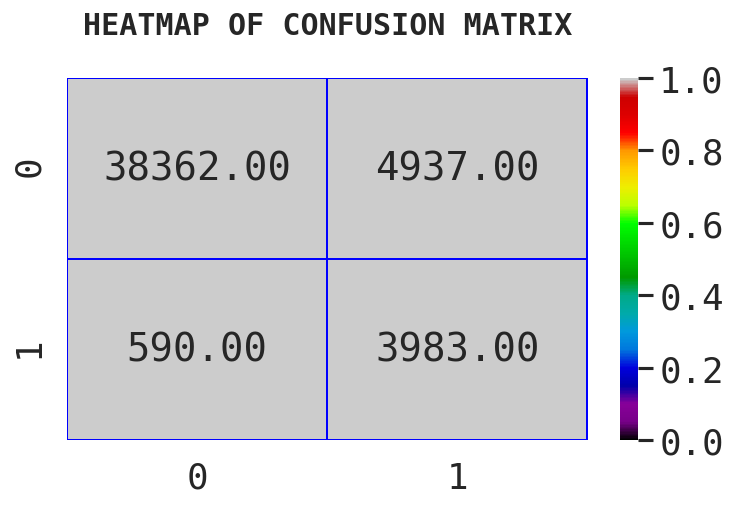



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9373328877005348

F1 score: 0.20424403183023873

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     47425
           1       0.12      0.86      0.20       447

    accuracy                           0.94     47872
   macro avg       0.56      0.90      0.59     47872
weighted avg       0.99      0.94      0.96     47872


PRECISION:
 0.11585916340656034

RECALL:
 0.8612975391498882

MEAN SQUARED ERROR:
 0.06266711229946524

ROOT MEAN SQ. ERROR:
 0.2503340014849466

LOG_LOSS: 2.16449445191306

AUC_ROC Score:
 0.8996735455369895

TPR: [0.         0.06195045 1.        ] 
FPR: [0.         0.86129754 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



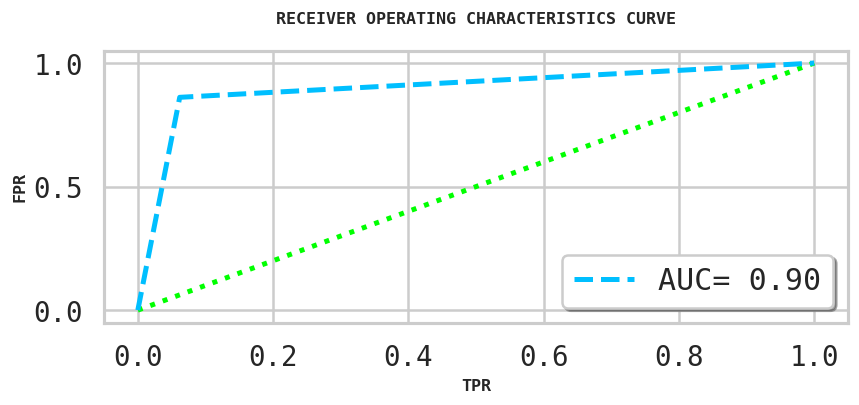





	____________________________________________CONFUSION MATRIX___________________________________________



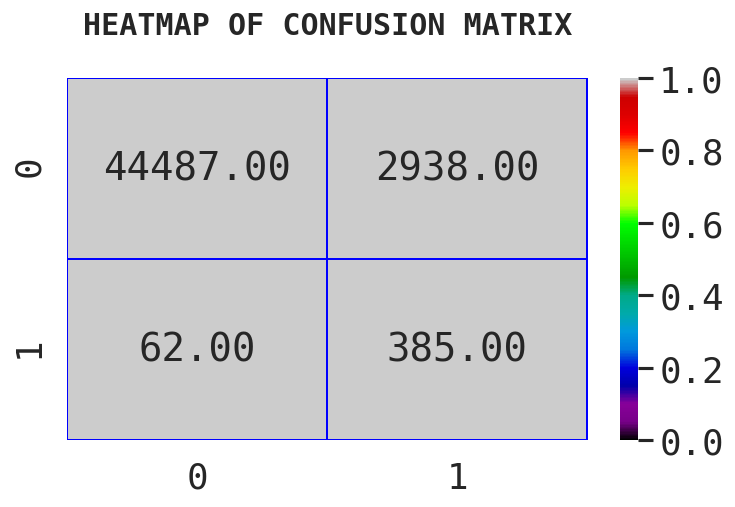



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9063126671122995

F1 score: 0.49533025767975697

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     45359
           1       0.35      0.88      0.50      2513

    accuracy                           0.91     47872
   macro avg       0.67      0.89      0.72     47872
weighted avg       0.96      0.91      0.92     47872


PRECISION:
 0.345309068089112

RECALL:
 0.8758456028651015

MEAN SQUARED ERROR:
 0.09368733288770054

ROOT MEAN SQ. ERROR:
 0.30608386577488944

LOG_LOSS: 3.235915542514427

AUC_ROC Score:
 0.8919231100813304

TPR: [0.         0.09199938 1.        ] 
FPR: [0.        0.8758456 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



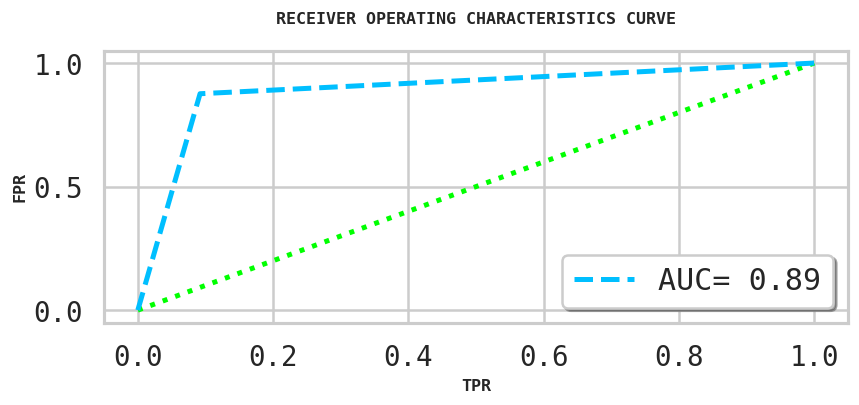





	____________________________________________CONFUSION MATRIX___________________________________________



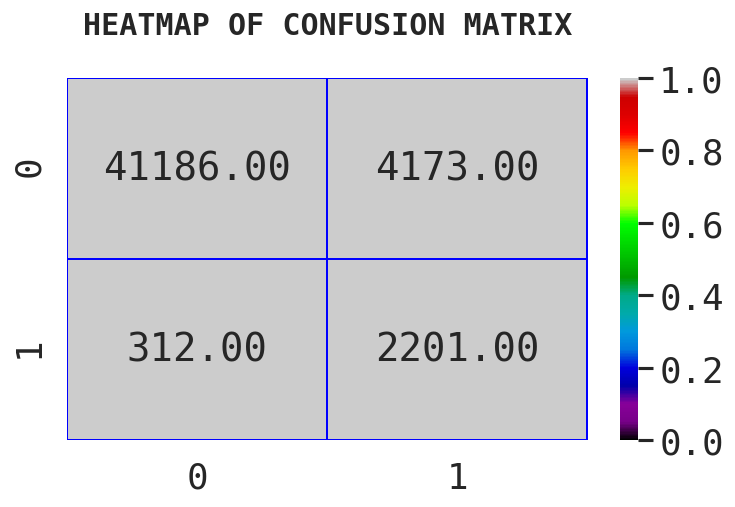



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9491143048128342

F1 score: 0.06163328197226503

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     47737
           1       0.03      0.59      0.06       135

    accuracy                           0.95     47872
   macro avg       0.52      0.77      0.52     47872
weighted avg       1.00      0.95      0.97     47872


PRECISION:
 0.03250711093051605

RECALL:
 0.5925925925925926

MEAN SQUARED ERROR:
 0.05088569518716578

ROOT MEAN SQ. ERROR:
 0.2255785787417896

LOG_LOSS: 1.7575694171850718

AUC_ROC Score:
 0.771357569522515

TPR: [0.         0.04987745 1.        ] 
FPR: [0.         0.59259259 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



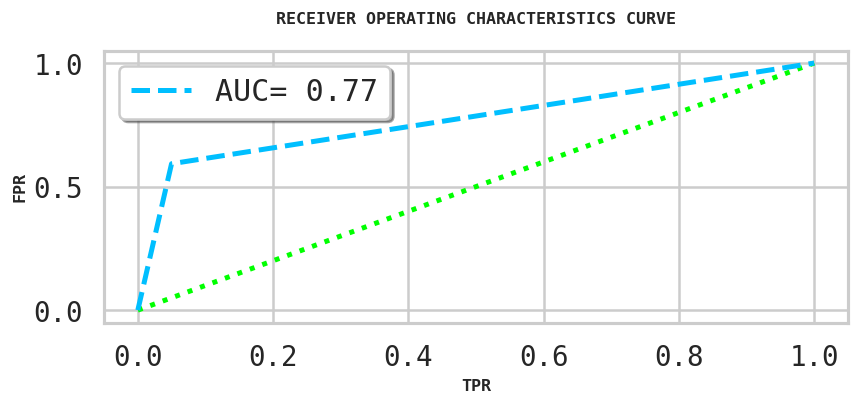





	____________________________________________CONFUSION MATRIX___________________________________________



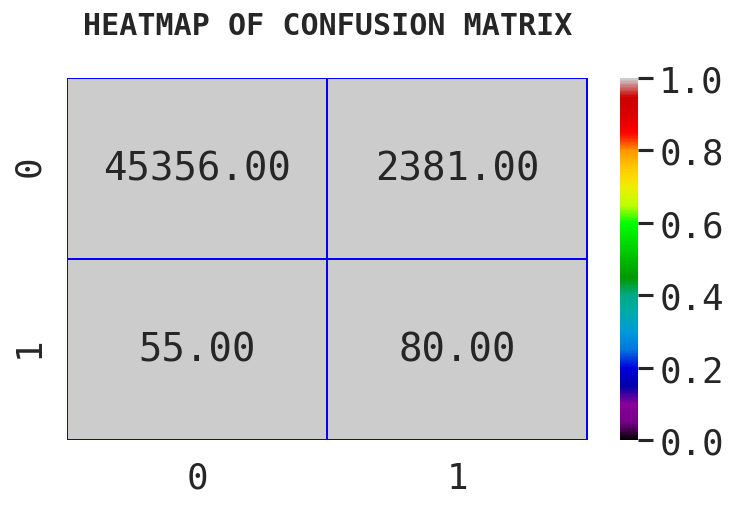



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9049548796791443

F1 score: 0.47423156921654724

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     45531
           1       0.33      0.88      0.47      2341

    accuracy                           0.90     47872
   macro avg       0.66      0.89      0.71     47872
weighted avg       0.96      0.90      0.92     47872


PRECISION:
 0.32504356090606684

RECALL:
 0.8765484835540367

MEAN SQUARED ERROR:
 0.09504512032085562

ROOT MEAN SQ. ERROR:
 0.30829388628523857

LOG_LOSS: 3.2828133289082073

AUC_ROC Score:
 0.8914819464178125

TPR: [0.         0.09358459 1.        ] 
FPR: [0.         0.87654848 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



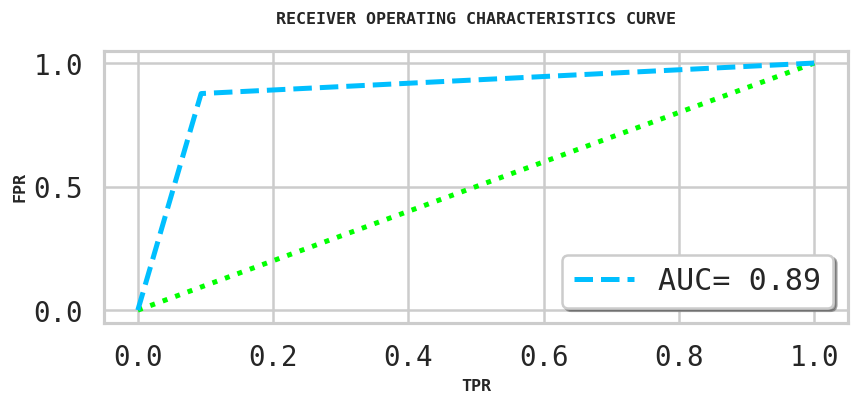





	____________________________________________CONFUSION MATRIX___________________________________________



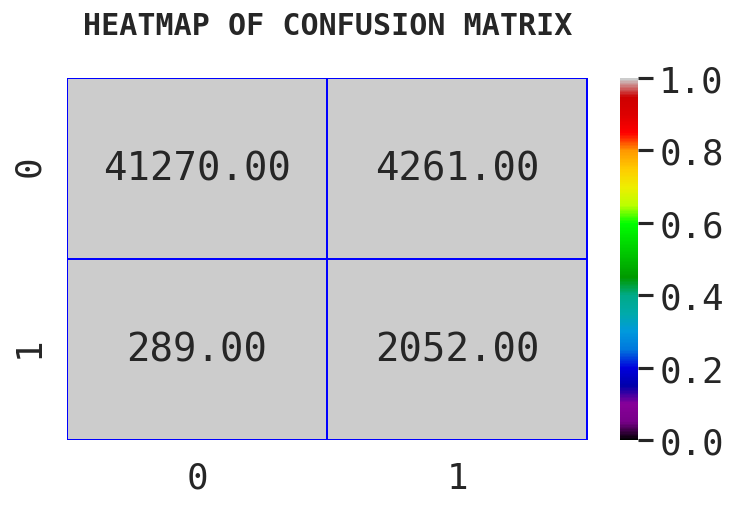



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9290190508021391

F1 score: 0.16015818091942657

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     47448
           1       0.09      0.76      0.16       424

    accuracy                           0.93     47872
   macro avg       0.54      0.85      0.56     47872
weighted avg       0.99      0.93      0.96     47872


PRECISION:
 0.0894533406957482

RECALL:
 0.7641509433962265

MEAN SQUARED ERROR:
 0.07098094919786097

ROOT MEAN SQ. ERROR:
 0.266422501297959

LOG_LOSS: 2.4516502185459412

AUC_ROC Score:
 0.8473216359199983

TPR: [0.         0.06950767 1.        ] 
FPR: [0.         0.76415094 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



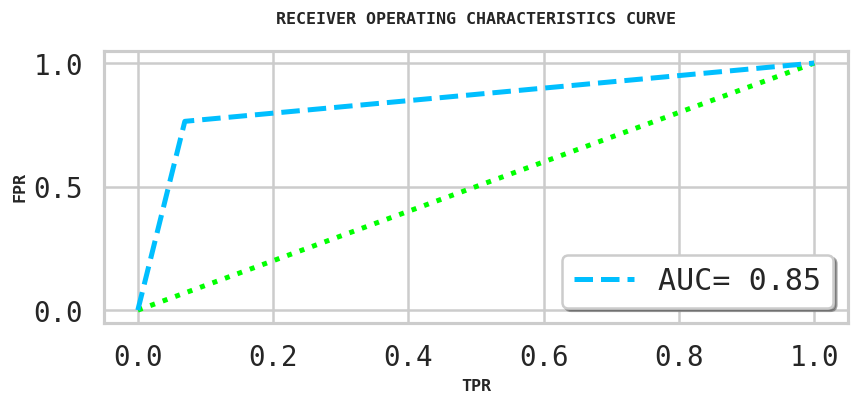





	____________________________________________CONFUSION MATRIX___________________________________________



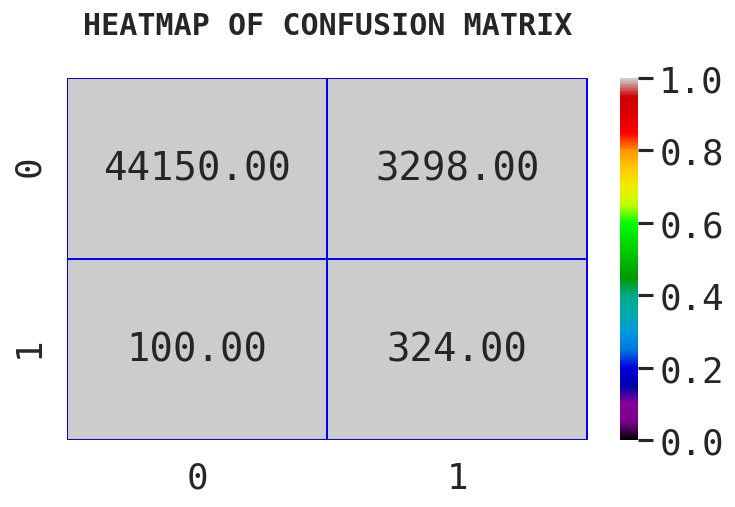



Processing normal
-------------------------------------
ACCURACY SCORE: 0.8726604278074866

F1 score: 0.9248224151539068

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.44      0.88      0.58      4844
           1       0.99      0.87      0.92     43028

    accuracy                           0.87     47872
   macro avg       0.71      0.88      0.75     47872
weighted avg       0.93      0.87      0.89     47872


PRECISION:
 0.9851812926957436

RECALL:
 0.8714325555452264

MEAN SQUARED ERROR:
 0.12733957219251338

ROOT MEAN SQ. ERROR:
 0.35684670685395625

LOG_LOSS: 4.398162430571653

AUC_ROC Score:
 0.8774999276487486

TPR: [0.        0.1164327 1.       ] 
FPR: [0.         0.87143256 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



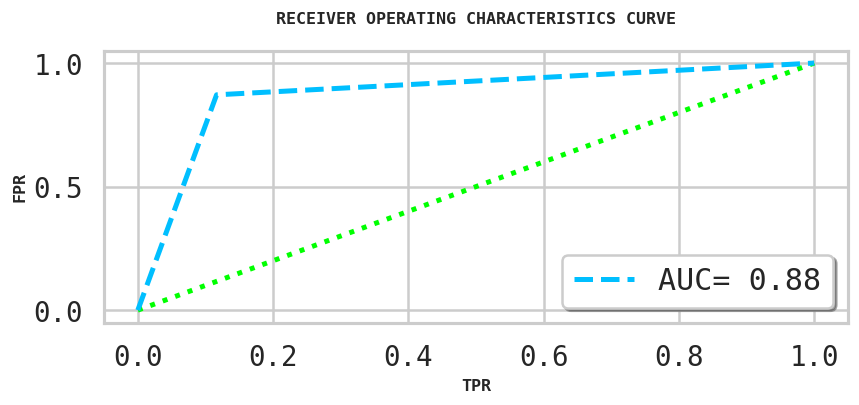





	____________________________________________CONFUSION MATRIX___________________________________________



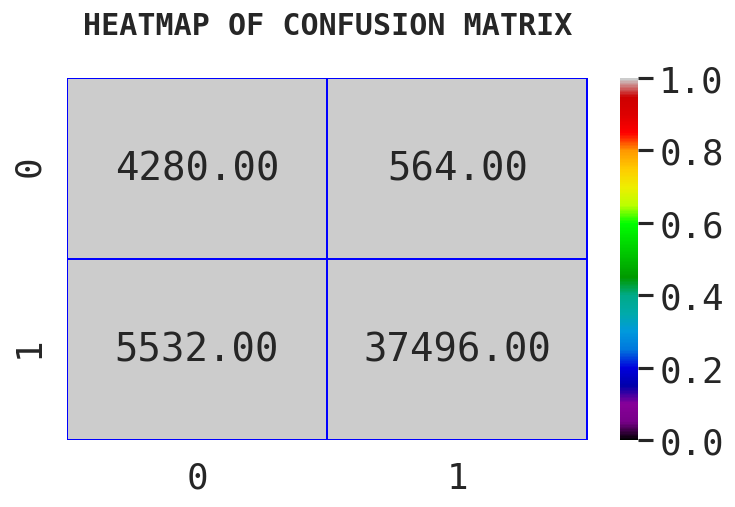

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.590380,0.884546,0.446525,0.870982,0.339785,0.115454,0.878480,3.987712
1,highly_malignant,0.204244,0.937333,0.115859,0.861298,0.250334,0.062667,0.899674,2.164494
2,rude,0.495330,0.906313,0.345309,0.875846,0.306084,0.093687,0.891923,3.235916
3,threat,0.061633,0.949114,0.032507,0.592593,0.225579,0.050886,0.771358,1.757569
4,abuse,0.474232,0.904955,0.325044,0.876548,0.308294,0.095045,0.891482,3.282813
5,loathe,0.160158,0.929019,0.089453,0.764151,0.266423,0.070981,0.847322,2.451650
6,normal,0.924822,0.872660,0.985181,0.871433,0.356847,0.127340,0.877500,4.398162


In [52]:
CNB_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    CNB_pipeline.fit(x_train, y_train[category])
    pred = CNB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model
cnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
cnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

### LINEAR SVC

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.8845462901069518

F1 score: 0.5903801971392574

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93     43299
           1       0.45      0.87      0.59      4573

    accuracy                           0.88     47872
   macro avg       0.72      0.88      0.76     47872
weighted avg       0.93      0.88      0.90     47872


PRECISION:
 0.44652466367713006

RECALL:
 0.8709818499890662

MEAN SQUARED ERROR:
 0.11545370989304812

ROOT MEAN SQ. ERROR:
 0.33978479938491674

LOG_LOSS: 3.98771233178443

AUC_ROC Score:
 0.8784803704782627

TPR: [0.         0.11402111 1.        ] 
FPR: [0.         0.87098185 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



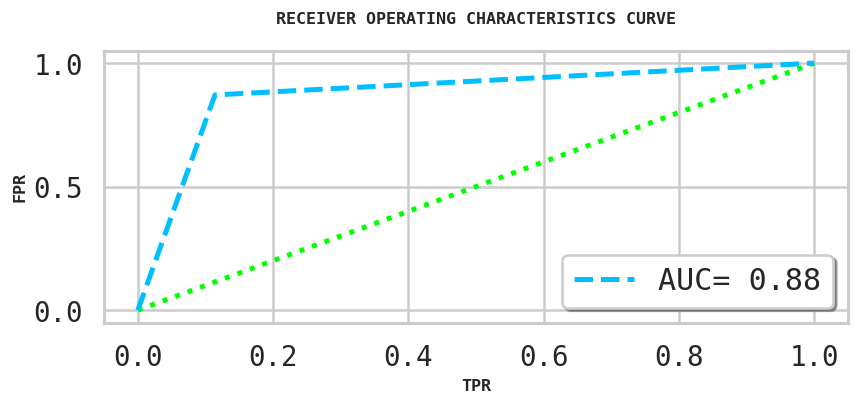





	____________________________________________CONFUSION MATRIX___________________________________________



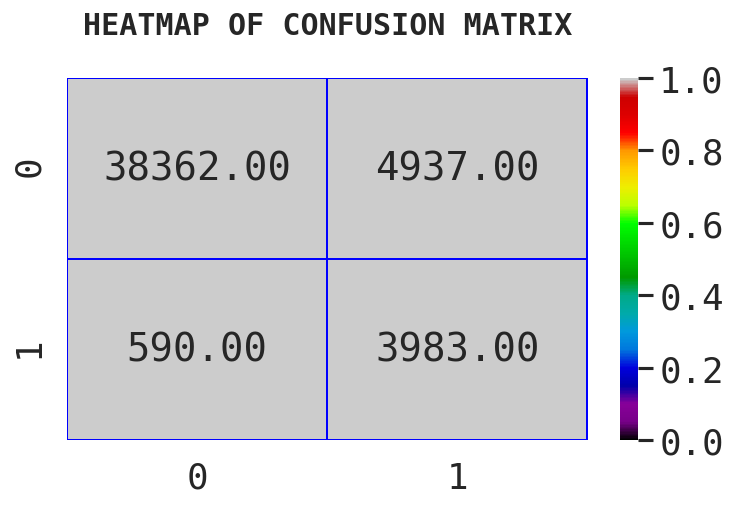



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9373328877005348

F1 score: 0.20424403183023873

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     47425
           1       0.12      0.86      0.20       447

    accuracy                           0.94     47872
   macro avg       0.56      0.90      0.59     47872
weighted avg       0.99      0.94      0.96     47872


PRECISION:
 0.11585916340656034

RECALL:
 0.8612975391498882

MEAN SQUARED ERROR:
 0.06266711229946524

ROOT MEAN SQ. ERROR:
 0.2503340014849466

LOG_LOSS: 2.16449445191306

AUC_ROC Score:
 0.8996735455369895

TPR: [0.         0.06195045 1.        ] 
FPR: [0.         0.86129754 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



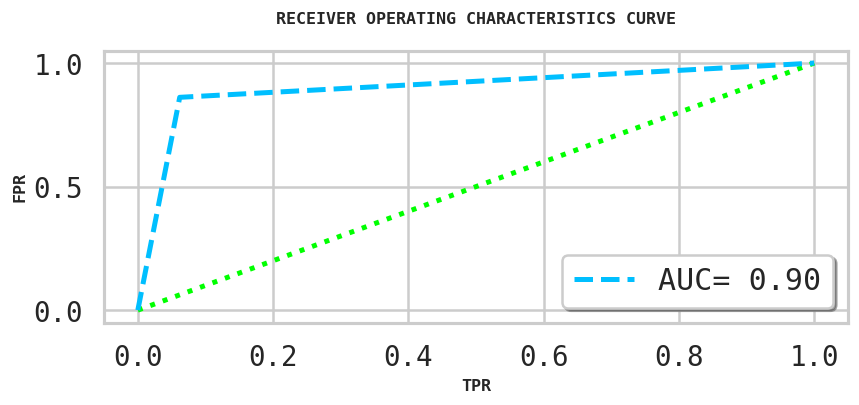





	____________________________________________CONFUSION MATRIX___________________________________________



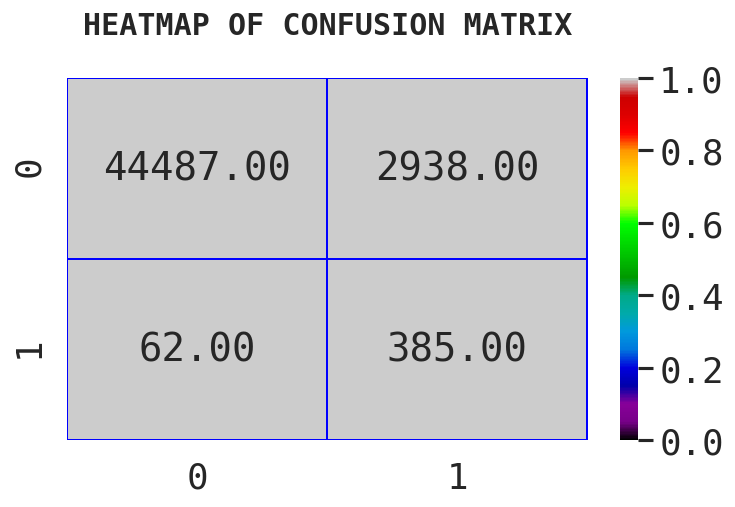



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9063126671122995

F1 score: 0.49533025767975697

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     45359
           1       0.35      0.88      0.50      2513

    accuracy                           0.91     47872
   macro avg       0.67      0.89      0.72     47872
weighted avg       0.96      0.91      0.92     47872


PRECISION:
 0.345309068089112

RECALL:
 0.8758456028651015

MEAN SQUARED ERROR:
 0.09368733288770054

ROOT MEAN SQ. ERROR:
 0.30608386577488944

LOG_LOSS: 3.235915542514427

AUC_ROC Score:
 0.8919231100813304

TPR: [0.         0.09199938 1.        ] 
FPR: [0.        0.8758456 1.       ]




	____________________________________________ROC_AUC CURVE_______________________________________________



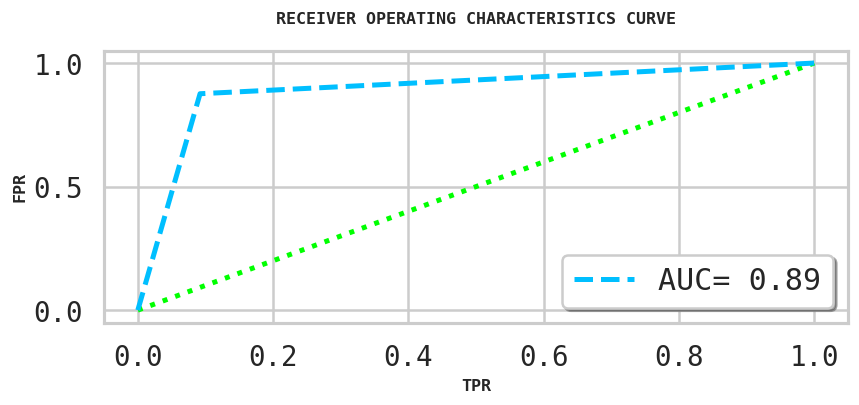





	____________________________________________CONFUSION MATRIX___________________________________________



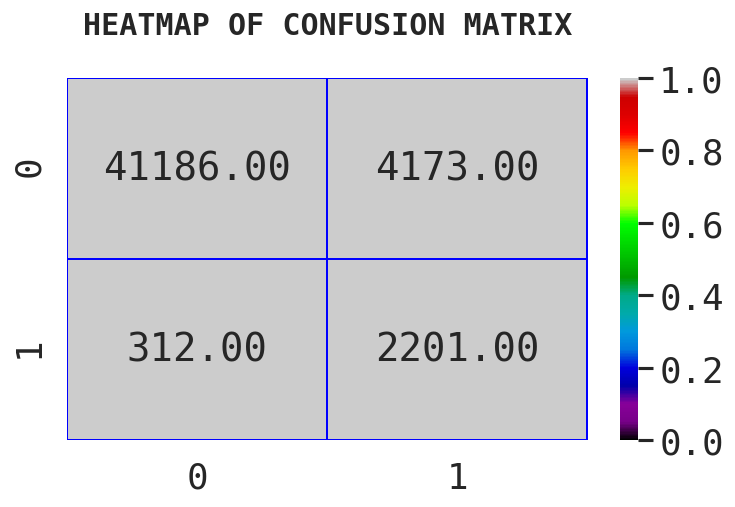



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9491143048128342

F1 score: 0.06163328197226503

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     47737
           1       0.03      0.59      0.06       135

    accuracy                           0.95     47872
   macro avg       0.52      0.77      0.52     47872
weighted avg       1.00      0.95      0.97     47872


PRECISION:
 0.03250711093051605

RECALL:
 0.5925925925925926

MEAN SQUARED ERROR:
 0.05088569518716578

ROOT MEAN SQ. ERROR:
 0.2255785787417896

LOG_LOSS: 1.7575694171850718

AUC_ROC Score:
 0.771357569522515

TPR: [0.         0.04987745 1.        ] 
FPR: [0.         0.59259259 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



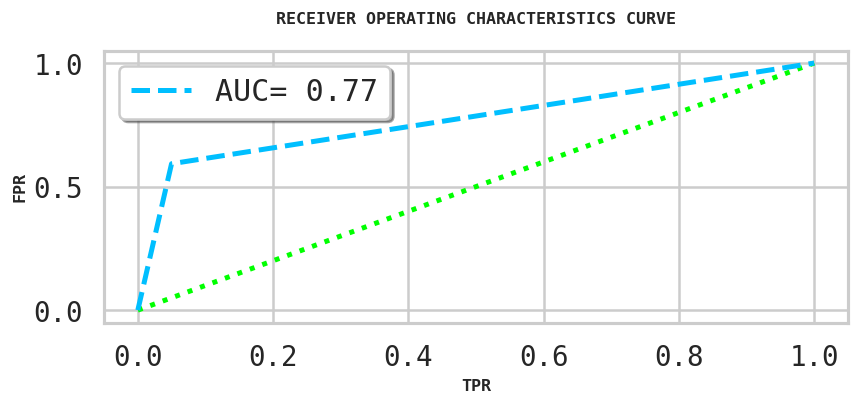





	____________________________________________CONFUSION MATRIX___________________________________________



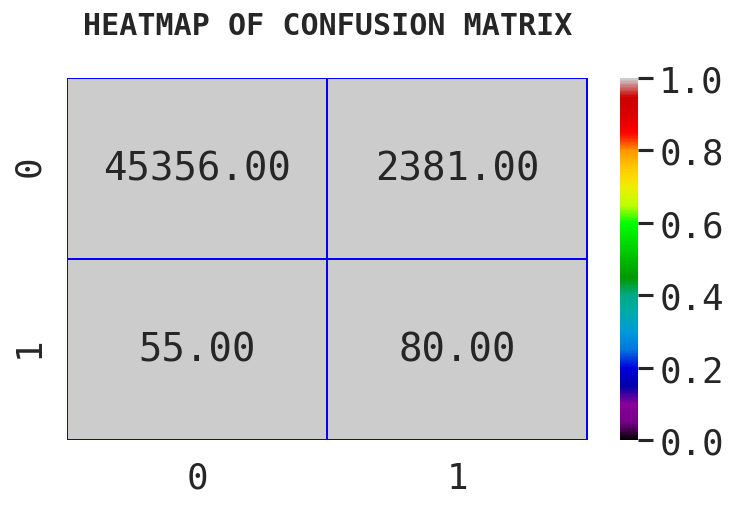



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9049548796791443

F1 score: 0.47423156921654724

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     45531
           1       0.33      0.88      0.47      2341

    accuracy                           0.90     47872
   macro avg       0.66      0.89      0.71     47872
weighted avg       0.96      0.90      0.92     47872


PRECISION:
 0.32504356090606684

RECALL:
 0.8765484835540367

MEAN SQUARED ERROR:
 0.09504512032085562

ROOT MEAN SQ. ERROR:
 0.30829388628523857

LOG_LOSS: 3.2828133289082073

AUC_ROC Score:
 0.8914819464178125

TPR: [0.         0.09358459 1.        ] 
FPR: [0.         0.87654848 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



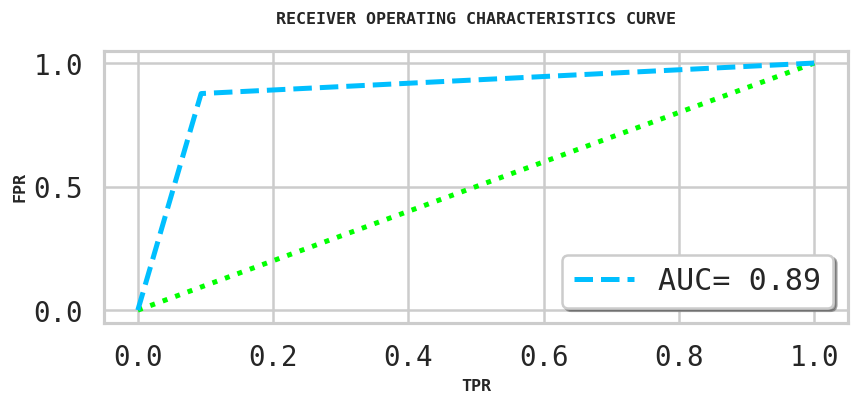





	____________________________________________CONFUSION MATRIX___________________________________________



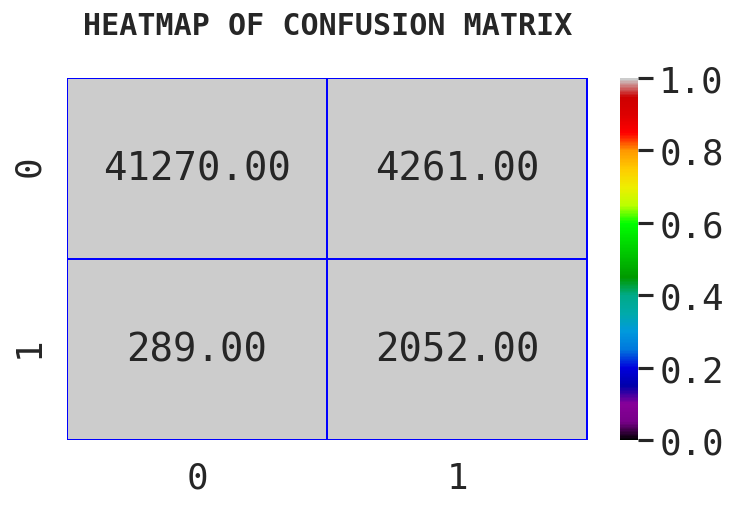



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9290190508021391

F1 score: 0.16015818091942657

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     47448
           1       0.09      0.76      0.16       424

    accuracy                           0.93     47872
   macro avg       0.54      0.85      0.56     47872
weighted avg       0.99      0.93      0.96     47872


PRECISION:
 0.0894533406957482

RECALL:
 0.7641509433962265

MEAN SQUARED ERROR:
 0.07098094919786097

ROOT MEAN SQ. ERROR:
 0.266422501297959

LOG_LOSS: 2.4516502185459412

AUC_ROC Score:
 0.8473216359199983

TPR: [0.         0.06950767 1.        ] 
FPR: [0.         0.76415094 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



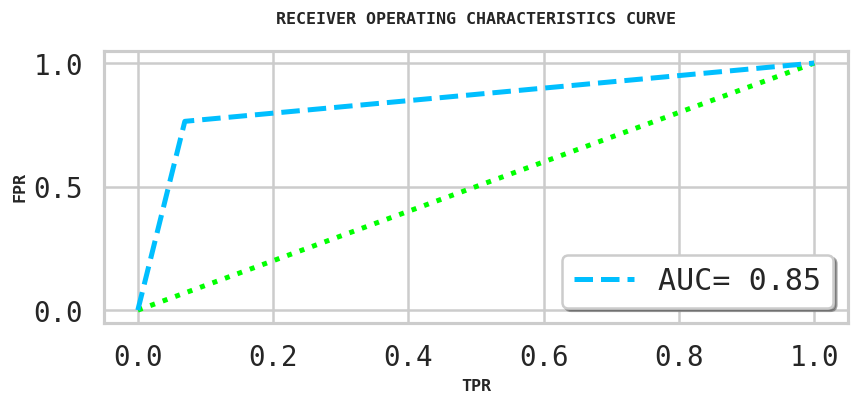





	____________________________________________CONFUSION MATRIX___________________________________________



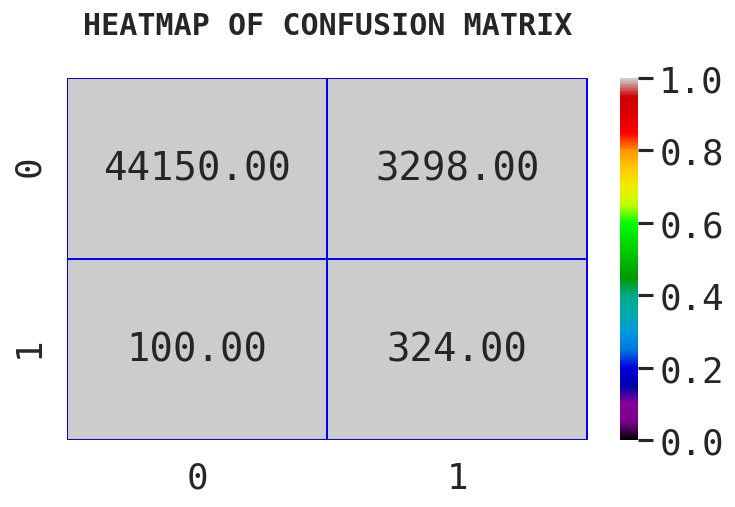



Processing normal
-------------------------------------
ACCURACY SCORE: 0.8726604278074866

F1 score: 0.9248224151539068

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.44      0.88      0.58      4844
           1       0.99      0.87      0.92     43028

    accuracy                           0.87     47872
   macro avg       0.71      0.88      0.75     47872
weighted avg       0.93      0.87      0.89     47872


PRECISION:
 0.9851812926957436

RECALL:
 0.8714325555452264

MEAN SQUARED ERROR:
 0.12733957219251338

ROOT MEAN SQ. ERROR:
 0.35684670685395625

LOG_LOSS: 4.398162430571653

AUC_ROC Score:
 0.8774999276487486

TPR: [0.        0.1164327 1.       ] 
FPR: [0.         0.87143256 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



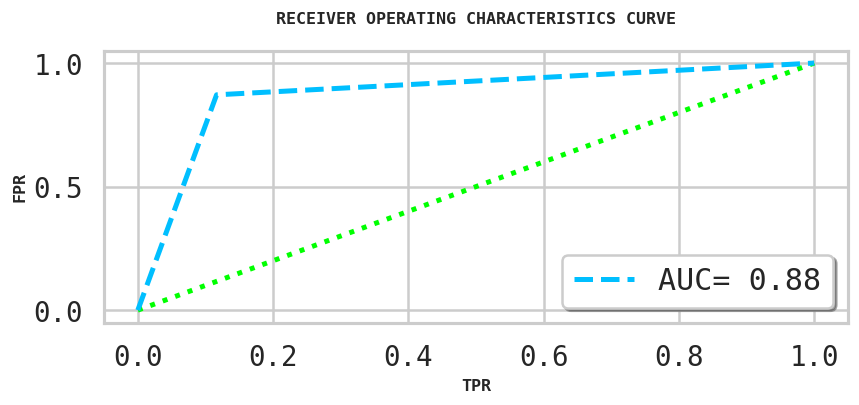





	____________________________________________CONFUSION MATRIX___________________________________________



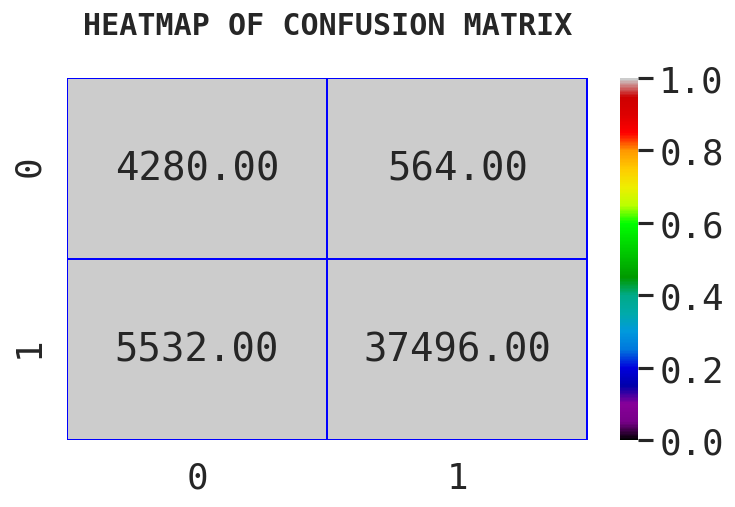

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.590380,0.884546,0.446525,0.870982,0.339785,0.115454,0.878480,3.987712
1,highly_malignant,0.204244,0.937333,0.115859,0.861298,0.250334,0.062667,0.899674,2.164494
2,rude,0.495330,0.906313,0.345309,0.875846,0.306084,0.093687,0.891923,3.235916
3,threat,0.061633,0.949114,0.032507,0.592593,0.225579,0.050886,0.771358,1.757569
4,abuse,0.474232,0.904955,0.325044,0.876548,0.308294,0.095045,0.891482,3.282813
5,loathe,0.160158,0.929019,0.089453,0.764151,0.266423,0.070981,0.847322,2.451650
6,normal,0.924822,0.872660,0.985181,0.871433,0.356847,0.127340,0.877500,4.398162


In [53]:
svc_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    svc_pipeline.fit(x_train, y_train[category])
    pred = svc_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model
lsvc_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
lsvc_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

In [54]:
#printing all the dataframe at one place

print('\nRESULTS OBTAINED FROM LOGISTIC REGRESSION\n')
display(logi_results)
print('\nRESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER\n')
display(pac_results)
print('\nRESULTS OBTAINED FROM MULTINOMIAL NB\n')
display(mnb_results)
print('\nRESULTS OBTAINED FROM COMPLEMENT NB\n')
display(cnb_results)
print('\nRESULTS OBTAINED FROM LINER SVC\n')
display(lsvc_results)


RESULTS OBTAINED FROM LOGISTIC REGRESSION



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.723549,0.956008,0.905090,0.602668,0.209743,0.043992,0.797997,1.519445
1,highly_malignant,0.267091,0.990370,0.461538,0.187919,0.098132,0.009630,0.592927,0.332605
2,rude,0.746185,0.977419,0.910080,0.632312,0.150270,0.022581,0.814425,0.779924
3,threat,0.120000,0.997243,0.600000,0.066667,0.052511,0.002757,0.533270,0.095236
4,abuse,0.622656,0.970150,0.815353,0.503631,0.172773,0.029850,0.748883,1.031002
5,loathe,0.262357,0.991895,0.676471,0.162736,0.090027,0.008105,0.581020,0.279935
6,normal,0.975675,0.955465,0.958270,0.993725,0.211034,0.044535,0.804666,1.538230



RESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.649180,0.916465,0.542045,0.809097,0.289025,0.083535,0.868451,2.885258
1,highly_malignant,0.354667,0.989890,0.438944,0.297539,0.100550,0.010110,0.646977,0.349200
2,rude,0.715600,0.967706,0.665412,0.773975,0.179707,0.032294,0.876207,1.115427
3,threat,0.325123,0.997138,0.485294,0.244444,0.053496,0.002862,0.621856,0.098844
4,abuse,0.613074,0.961794,0.607293,0.618966,0.195464,0.038206,0.799193,1.319606
5,loathe,0.433735,0.990182,0.443350,0.424528,0.099085,0.009818,0.709883,0.339100
6,normal,0.971093,0.947903,0.968623,0.973575,0.228248,0.052097,0.846717,1.799398



RESULTS OBTAINED FROM MULTINOMIAL NB



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.640663,0.947464,0.924155,0.490269,0.229207,0.052536,0.743010,1.814530
1,highly_malignant,0.242879,0.989451,0.368182,0.181208,0.102708,0.010549,0.589139,0.364351
2,rude,0.639857,0.970442,0.887712,0.500199,0.171924,0.029558,0.748347,1.020899
3,threat,0.027523,0.995572,0.036145,0.022222,0.066547,0.004428,0.510273,0.152955
4,abuse,0.542460,0.966348,0.809322,0.407945,0.183445,0.033652,0.701502,1.162311
5,loathe,0.092362,0.989326,0.187050,0.061321,0.103316,0.010674,0.529470,0.368679
6,normal,0.970960,0.946441,0.946978,0.996189,0.231429,0.053559,0.750365,1.849919



RESULTS OBTAINED FROM COMPLEMENT NB



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.590380,0.884546,0.446525,0.870982,0.339785,0.115454,0.878480,3.987712
1,highly_malignant,0.204244,0.937333,0.115859,0.861298,0.250334,0.062667,0.899674,2.164494
2,rude,0.495330,0.906313,0.345309,0.875846,0.306084,0.093687,0.891923,3.235916
3,threat,0.061633,0.949114,0.032507,0.592593,0.225579,0.050886,0.771358,1.757569
4,abuse,0.474232,0.904955,0.325044,0.876548,0.308294,0.095045,0.891482,3.282813
5,loathe,0.160158,0.929019,0.089453,0.764151,0.266423,0.070981,0.847322,2.451650
6,normal,0.924822,0.872660,0.985181,0.871433,0.356847,0.127340,0.877500,4.398162



RESULTS OBTAINED FROM LINER SVC



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.590380,0.884546,0.446525,0.870982,0.339785,0.115454,0.878480,3.987712
1,highly_malignant,0.204244,0.937333,0.115859,0.861298,0.250334,0.062667,0.899674,2.164494
2,rude,0.495330,0.906313,0.345309,0.875846,0.306084,0.093687,0.891923,3.235916
3,threat,0.061633,0.949114,0.032507,0.592593,0.225579,0.050886,0.771358,1.757569
4,abuse,0.474232,0.904955,0.325044,0.876548,0.308294,0.095045,0.891482,3.282813
5,loathe,0.160158,0.929019,0.089453,0.764151,0.266423,0.070981,0.847322,2.451650
6,normal,0.924822,0.872660,0.985181,0.871433,0.356847,0.127340,0.877500,4.398162


```basing on the above results using  LOGISTIC REGESSION   as final model```

In [55]:
LogReg_pipeline

Pipeline(steps=[('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(solver='sag'),
                                     n_jobs=1))])

In [56]:
joblib.dump(LogReg_pipeline,'COMMENT_LOGI.pkl')

['COMMENT_LOGI.pkl']

In [57]:
#loading the model
model=joblib.load('COMMENT_LOGI.pkl')

In [58]:
test.head(7)

,comment_text,comment
0,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succes ever hate sad mofuckasi bitc...
1,== From RfC == \n\n The title is fine as it is...,rfc titl fine imo
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sourc zaw ashton lapland
3,":If you have a look back at the source, the in...",look sourc inform updat correct form guess sou...
4,I don't anonymously edit articles at all.,anonym edit articl
5,Thank you for understanding. I think very high...,thank think highli revert discuss
6,Please do not add nonsense to Wikipedia. Such ...,pleas add nonsens wikipedia edit consid vandal...


In [59]:
X=test['comment']
X

0         bitch rule succes ever hate sad mofuckasi bitc...
1                                         rfc titl fine imo
2                                  sourc zaw ashton lapland
3         look sourc inform updat correct form guess sou...
4                                        anonym edit articl
                                ...                        
153159                    total agre stuff noth toolongcrap
153160    throw field home plate faster throw cut man di...
153161    categori chang agre correct gotten confus foun...
153162    one found nation germani law return quit simil...
153163    stop alreadi bullshit welcom fool think kind e...
Name: comment, Length: 153164, dtype: object

In [60]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=10000,ngram_range=(1,3))
test_x=tfidf.fit_transform(X)

In [61]:
test_x.shape

(153164, 10000)

In [62]:
result=model.predict(test_x)

In [63]:
display(result)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)